<a href="https://colab.research.google.com/github/trie0000/external/blob/main/code20260104_1022%EF%BC%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""DL_Basic_2025_Competition_NYUv2_baseline.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/17t7uAU0aST5aUt6sIJCqFneGlQrxFrJY

# Deep Learning 基礎講座　最終課題: NYUv2 セマンティックセグメンテーションcoarse_w=0」

## 概要
RGB画像から、画像内の各ピクセルがどのクラスに属するかを予測するセマンティックセグメンテーションタスク.

### データセット
- データセット: NYUv2 dataset
- 訓練データ: 795枚
- テストデータ: 654枚
- 入力: RGB画像 + 深度マップ（元画像サイズは可変）
- 出力: 13クラスのセグメンテーションマップ
- 評価指標: Mean IoU (Intersection over Union)

### データセットの詳細（[NYU Depth Dataset V2](https://cs.nyu.edu/~fergus/datasets/nyu_depth_v2.html)）
- 画像は屋内シーンを撮影したもので、家具や壁、床などの物体が含まれています.
- 各画像に対して13クラスのセグメンテーションラベルが提供されます.
- データは以下のディレクトリ構造で提供:
```
data/NYUv2/
├─train/
│  ├─image/      # RGB画像
│  │    000000.png
│  │    ...
│  │
│  ├─depth/      # 深度マップ
│  │    000000.png
│  │    ...
│  │
│  └─label/      # 13クラスセグメンテーション（教師ラベル）
│       000000.png
│       ...
└─test/
   ├─image/      # RGB画像
   │    000000.png
   │    ...
   │  ├─depth/   # 深度マップ
   │    000000.png
   │    ...
```

### タスクの詳細
- 入力のRGB画像と深度マップから、各ピクセルが13クラスのどれに属するかを予測するタスクです.
- 評価はMean IoUを使用します．
  - 各クラスごとにIoUを計算し、その平均を取ります.
  - IoUは以下の式で計算:
  $$IoU = \frac{TP}{TP + FP + FN}$$
    - TP: True Positive（正しく予測されたピクセル数）
    - FP: False Positive（誤って予測されたピクセル数）
    - FN: False Negative（見逃したピクセル数）

### 前処理
- 入力画像は512×512にリサイズされます.
- ピクセル値は0-1に正規化されます.
- セグメンテーションラベルは0-12の整数値（13クラス）です．
  - 255はignore index（評価から除外）

### 提出形式
- テスト画像（RGB + Depth）の各ピクセルに対してクラス（0~12）を予測したものをnumpy配列として保存されます.
- ファイル名: `submission.npy`
- 配列の形状: [テストデータ数, 高さ, 幅]
- 各ピクセルの値: 0-12の整数（予測クラス）

## 考えられる工夫の例
- 事前学習モデルの fine-tuning
    - ImageNetなどで事前学習されたモデルを本データセットでfine-tuningすることで性能向上が見込めます.
- 損失関数の再設計
    - クラスごとの出現頻度に応じて損失を補正するように損失関数を設計すると、クラス分布の不均衡に対してロバストな学習ができます.
- 画像の前処理
    - RandomResizedCrop / Flip / ColorJitter 等のデータ拡張を追加することで，汎化性能の向上が見込めます．

## 修了要件を満たす条件
- ベースラインでは，omnicampus 上での性能評価において， 38.2% となります．したがって，ベースラインである 38.2% を超えた提出のみ，修了要件として認めます．
- ベースラインから改善を加えることで， 50%以上に性能向上することを運営で確認しています．こちらを 1つの指標として取り組んでみてください．

## 注意点
- 最終的な予測モデルは，**配布している訓練データを用いて学習**（ファインチューニング含む）したものとしてください．
- 学習を行わず，**事前学習済みモデルの知識のみを利用した推論は禁止**します．
（例: ChatGPT 等の LLM に入力して推論を得るのみ）

### 事前学習モデルの利用
許可される事項
- **構成要素としての事前学習モデルの利用**: 自身で実装したアーキテクチャの一部（特徴抽出，埋め込みなど）として事前学習モデル（BERT，ViT など）を利用することは可能です．
- **ファインチューニング**: 上記の用途で利用している事前学習モデルのファインチューニングは可能です．

禁止される事項
- **タスク解決用の事前学習モデルの利用**: transformers などで提供されている，対象タスクを直接解くための事前学習モデルでそのまま推論のみ，またはファインチューニングのみで利用することは禁止とします．
  - 禁止事項の例: VQA タスクを直接解くための事前学習モデルを VQA タスクで利用する．

### データの準備
データをダウンロードした際に，google drive したため，利用するために google drive をマウントする必要があります．また， drive 上で展開することができないため，/content ディレクトリ下にコピーし "data.zip" を展開します．
google drive 上に "data.zip" が配置されていない場合は実行できません．google drive 上に "data.zip" (**831MB**) を配置することが可能であれば，"data_download.ipynb" を先に実行してください．難しい場合は，omnicampus 演習環境を利用してください．．
"""

# omnicampus 上では 4 セル目まで実行不要
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

# データダウンロード用の notebook にてgoogle drive への保存後，
# 反映に時間がかかる可能性がありますので，google drive のマウント後，
# data.zip がディレクトリ内にあることを確認してから実行してください．
# data.zip を /content 下にコピーする
!cp "/content/drive/MyDrive/data.zip" "/content"

# Commented out IPython magic to ensure Python compatibility.
# カレントディレクトリ下のファイル群を確認
# data.zip が表示されれば問題ないです
# %ls

# データを解凍する
!unzip data.zip
!mkdir data
!mv train test data/

"""omnicampus 演習環境では，data_download.ipynb のマウント，zip 化，drive へのコピーを実行しないことで，"data.zip" を解凍した形で配置されます．したがって，data ディレクトリが存在するディレクトリをカレントディレクトリとするだけで良いです．


"""

# Commented out IPython magic to ensure Python compatibility.
# omnicampus 実行用
# 以下の例では/workspace/Segmentation/split_data_scripts/omnicampus に data ディレクトリがあると想定
# %cd /workspace/Segmentation/split_data_scripts_omnicampus

# omnicampus 実行用
!pip install h5py scikit-image

"""# import library"""

Mounted at /content/drive
Archive:  data.zip
  inflating: data/train/image/000600.png  
  inflating: data/train/image/000320.png  
  inflating: data/train/image/000491.png  
  inflating: data/train/image/000502.png  
  inflating: data/train/image/000129.png  
  inflating: data/train/image/000044.png  
  inflating: data/train/image/000652.png  
  inflating: data/train/image/000919.png  
  inflating: data/train/image/000528.png  
  inflating: data/train/image/000853.png  
  inflating: data/train/image/000177.png  
  inflating: data/train/image/000584.png  
  inflating: data/train/image/001319.png  
  inflating: data/train/image/000597.png  
  inflating: data/train/image/000223.png  
  inflating: data/train/image/001350.png  
  inflating: data/train/image/000404.png  
  inflating: data/train/image/000488.png  
  inflating: data/train/image/000268.png  
  inflating: data/train/image/000481.png  
  inflating: data/train/image/000341.png  
  inflating: data/train/image/000159.png  
  inflati

'# import library'

In [ ]:
# =========================
# UNUSED: Focal CE
# 使う条件: config.use_focal=True
# =========================
import torch
import torch.nn as nn

def focal_ce_loss(logits, target, weight=None, ignore_index=255, gamma=2.0):
    ce = nn.functional.cross_entropy(
        logits, target, weight=weight, ignore_index=ignore_index, reduction="none"
    )
    pt = torch.exp(-ce)
    loss = ((1 - pt) ** gamma) * ce
    valid = (target != ignore_index)
    denom = valid.sum().clamp_min(1)
    return (loss * valid).sum() / denom

# =========================
# UNUSED: Boundary mask / dilation / loss
# 使う条件: config.boundary_w>0 かつ model.use_boundary_head=True
# =========================
import torch
import torch.nn as nn

def boundary_mask_from_label(label, ignore_index=255):
    valid = (label != ignore_index)
    b = torch.zeros_like(label, dtype=torch.bool)
    b[:, 1:, :] |= (label[:, 1:, :] != label[:, :-1, :])
    b[:, :-1, :] |= (label[:, :-1, :] != label[:, 1:, :])
    b[:, :, 1:] |= (label[:, :, 1:] != label[:, :, :-1])
    b[:, :, :-1] |= (label[:, :, :-1] != label[:, :, 1:])
    b &= valid
    return b

def dilate_mask(mask_bool, radius: int):
    if radius <= 0:
        return mask_bool
    x = mask_bool.float().unsqueeze(1)  # [B,1,H,W]
    k = 2 * radius + 1
    y = nn.functional.max_pool2d(x, kernel_size=k, stride=1, padding=radius)
    return (y.squeeze(1) > 0.5)

def boundary_focal_bce_dice_loss(
    boundary_logit, label,
    ignore_index=255,
    radius=2,
    gamma=2.0,
    alpha=0.25,
    dice_w=0.5,
    eps=1e-6
):
    with torch.no_grad():
        b0 = boundary_mask_from_label(label, ignore_index=ignore_index)
        b = dilate_mask(b0, radius=radius).float()
        valid = (label != ignore_index).float()

    logit = boundary_logit.squeeze(1)  # [B,H,W]
    p = torch.sigmoid(logit)
    pt = p * b + (1 - p) * (1 - b)
    w = (alpha * b + (1 - alpha) * (1 - b)) * ((1 - pt).clamp_min(1e-6) ** gamma)

    bce = nn.functional.binary_cross_entropy_with_logits(logit, b, reduction="none")
    loss_focal = (w * bce * valid).sum() / (valid.sum().clamp_min(1.0))

    prob = p * valid
    target01 = b * valid
    inter = (prob * target01).sum()
    union = prob.sum() + target01.sum()
    loss_dice = 1.0 - (2.0 * inter + eps) / (union + eps)

    return (1.0 - dice_w) * loss_focal + dice_w * loss_dice

# =========================
# UNUSED: Coarse supervision helpers
# 使う条件: config.coarse_w>0 かつ 13->coarse(5) のmapを実装してCEする
# =========================
import torch
import torch.nn as nn

def downsample_label_nearest(label, size_hw):
    x = label.unsqueeze(1).float()
    x = nn.functional.interpolate(x, size=size_hw, mode="nearest")
    return x.squeeze(1).long()

In [2]:
# -*- coding: utf-8 -*-
"""
NYUv2 (13cls): ResNeXt101 + DeepLabV3+ (OS=8 + ASPP tuned) + Aug Fix
+ Boundary loss + OHEM CE + 2-phase schedule
+ Book binary head (BookRefiner) for post-correction
+ (Fix) Log format is STABLE + Console prints per-class metrics every epoch
+ (NEW) At end: auto-write to Google Drive (submission.zip, logs, best/final .pt)

前提:
- dataset_root = "/content/data"
- data/NYUv2/{train,test}/{image,depth,label}
- label: 0-12, ignore=255
"""

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import time
import random
import json
import shutil
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
from zipfile import ZipFile, ZIP_DEFLATED

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import models
from torch.amp import autocast, GradScaler

import albumentations as A
import cv2


# =========================
# Settings
# =========================
CLASS_NAMES = ["Bed", "Book", "Ceiling", "Chair", "Floor", "Cabinet", "Object", "Picture",
               "Sofa", "Desk", "TV", "Wall", "Window"]
NUM_CLASSES = 13
IGNORE_INDEX = 255

BOOK_ID = 1
CABINET_ID = 5
OBJECT_ID = 6
DESK_ID = 9
WALL_ID = 11

# Book補正をかけやすい「吸われ先」候補（必要なら増減OK）
BOOK_STEALER_IDS = {CABINET_ID, OBJECT_ID, DESK_ID, WALL_ID}


# =========================
# Seed
# =========================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


# =========================
# Helper
# =========================
def estimate_height_from_depth(depth_np: np.ndarray) -> np.ndarray:
    H, W = depth_np.shape
    y_grid = np.linspace(0, 1, H).reshape(H, 1).repeat(W, axis=1).astype(np.float32)
    height_map = y_grid * depth_np
    max_val = float(height_map.max())
    if max_val > 0:
        height_map /= max_val
    return height_map.astype(np.float32)


def fmt_metrics_console(tag: str, epoch: int, miou: float, class_iou, class_precision, class_recall):
    """
    Consoleに毎エポック出す用（固定フォーマット）
    - IoU/Prec/Rec をクラスごとに出す
    """
    print(f"[{tag}] Epoch {epoch:02d} | mIoU={miou:.5f}")
    header = f"{'Class':<10} {'IoU':>8} {'Prec':>8} {'Rec':>8}"
    print(header)
    print("-" * len(header))
    for i, name in enumerate(CLASS_NAMES):
        iou = class_iou[i]
        pr  = class_precision[i]
        rc  = class_recall[i]
        print(f"{name:<10} {iou:>8.3f} {pr:>8.3f} {rc:>8.3f}")


def try_mount_drive_and_prepare(timestamp: str, log_dir: str):
    """
    ColabならDriveマウントして、出力先フォルダを作る。
    失敗したら (None, None) を返す。
    """
    try:
        from google.colab import drive  # Colab only
        drive.mount("/content/drive", force_remount=False)

        drive_run_dir = Path("/content/drive/MyDrive/NYUv2_runs") / timestamp
        drive_run_dir.mkdir(parents=True, exist_ok=True)

        drive_logs_dir = drive_run_dir / log_dir
        print(f"[DRIVE] Output dir: {drive_run_dir}")
        return drive_run_dir, drive_logs_dir
    except Exception as e:
        print(f"[DRIVE] Mount skipped/failed: {e}")
        return None, None


# =========================
# Dataset
# =========================
class NYUv2Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, return_label=True):
        self.split = split
        self.transform = transform
        self.return_label = return_label

        src_split = 'train' if split in ['train', 'val'] else 'test'
        self.images_dir = os.path.join(root_dir, src_split, 'image')
        self.depths_dir = os.path.join(root_dir, src_split, 'depth')
        self.labels_dir = os.path.join(root_dir, src_split, 'label') if src_split == 'train' else None

        self.filenames = sorted([f for f in os.listdir(self.images_dir) if f.endswith('.png')])

        # RGB normalize (ImageNet)
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        self.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

        # depth/height normalize (rough)
        self.d_mean, self.d_std = 0.5, 0.25

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        rgb = np.array(Image.open(os.path.join(self.images_dir, fname)).convert('RGB'))
        depth = np.array(Image.open(os.path.join(self.depths_dir, fname)))
        if depth.ndim == 3:
            depth = depth[:, :, 0]

        depth = depth.astype(np.float32) / (65535.0 if depth.max() > 255 else 255.0)
        h_map = estimate_height_from_depth(depth)

        if self.labels_dir and self.return_label:
            label = np.array(Image.open(os.path.join(self.labels_dir, fname)))
        else:
            label = np.zeros(depth.shape, dtype=np.int32)

        if self.transform:
            augmented = self.transform(image=rgb, depth=depth, height=h_map, mask=label)
            rgb, depth, h_map, label = augmented['image'], augmented['depth'], augmented['height'], augmented['mask']

        rgb = (rgb.astype(np.float32) / 255.0 - self.mean) / self.std
        depth = (depth - self.d_mean) / self.d_std
        h_map = (h_map - self.d_mean) / self.d_std

        rgb_t = torch.from_numpy(rgb.transpose(2, 0, 1)).float()
        depth_t = torch.from_numpy(depth).unsqueeze(0).float()
        h_t = torch.from_numpy(h_map).unsqueeze(0).float()

        x = torch.cat([rgb_t, depth_t, h_t], dim=0)  # 5ch (RGB + depth + height)

        if self.split == 'test':
            return x, fname
        return x, torch.from_numpy(label).long()


# =========================
# Losses
# =========================
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, ignore_index=IGNORE_INDEX):
        super().__init__()
        self.weight = weight
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, logits, target):
        ce = F.cross_entropy(
            logits, target,
            weight=self.weight,
            ignore_index=self.ignore_index,
            reduction='none'
        )
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()


class ClassBalancedDiceLoss(nn.Module):
    def __init__(self, n_classes=NUM_CLASSES, smooth=1e-5, ignore_index=IGNORE_INDEX, class_weights=None):
        super().__init__()
        self.n_classes = n_classes
        self.smooth = smooth
        self.ignore_index = ignore_index
        self.class_weights = class_weights

    def forward(self, logits, target):
        prob = F.softmax(logits, dim=1)
        mask = (target != self.ignore_index)
        t = target.clone()
        t[~mask] = 0
        onehot = F.one_hot(t, self.n_classes).permute(0, 3, 1, 2).float()

        m = mask.unsqueeze(1).expand_as(prob)
        prob = prob * m
        onehot = onehot * m

        inter = (prob * onehot).sum(dim=(2, 3))
        union = prob.sum(dim=(2, 3)) + onehot.sum(dim=(2, 3))
        dice = (2 * inter + self.smooth) / (union + self.smooth)

        if self.class_weights is not None:
            dice_c = dice.mean(dim=0)
            w = self.class_weights.to(dice.device)
            weighted = (dice_c * w).sum() / (w.sum() + 1e-12)
            return 1 - weighted
        return 1 - dice.mean()


def make_boundary_mask(target: torch.Tensor, ignore_index=IGNORE_INDEX, dilate=2) -> torch.Tensor:
    valid = (target != ignore_index)
    t = target.clone()
    t[~valid] = -1

    up    = torch.zeros_like(t); up[:, 1:]    = t[:, :-1]
    down  = torch.zeros_like(t); down[:, :-1] = t[:, 1:]
    left  = torch.zeros_like(t); left[:, :, 1:]  = t[:, :, :-1]
    right = torch.zeros_like(t); right[:, :, :-1] = t[:, :, 1:]

    edge = ((t != up) | (t != down) | (t != left) | (t != right)) & valid
    edge = edge.float().unsqueeze(1)

    for _ in range(max(0, dilate)):
        edge = F.max_pool2d(edge, kernel_size=3, stride=1, padding=1)
    return (edge > 0).float()


def dice_loss_binary(logits: torch.Tensor, target: torch.Tensor, eps=1e-6) -> torch.Tensor:
    prob = torch.sigmoid(logits)
    inter = (prob * target).sum(dim=(2, 3))
    union = prob.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2 * inter + eps) / (union + eps)
    return 1 - dice.mean()


def ohem_cross_entropy(
    logits: torch.Tensor,
    target: torch.Tensor,
    weight: torch.Tensor,
    ignore_index=IGNORE_INDEX,
    min_kept=131072,
    thresh=0.7
) -> torch.Tensor:
    with torch.no_grad():
        prob = F.softmax(logits, dim=1)
        valid = (target != ignore_index)
        t_safe = target.clone()
        t_safe[~valid] = 0
        p_gt = prob.gather(1, t_safe.unsqueeze(1)).squeeze(1)
        hard = (p_gt < thresh) & valid

    loss = F.cross_entropy(logits, target, weight=weight, ignore_index=ignore_index, reduction='none')
    loss_valid = loss[valid]
    if loss_valid.numel() == 0:
        return loss.mean()

    loss_hard = loss[hard]
    if loss_hard.numel() >= min_kept:
        return torch.topk(loss_hard, k=min_kept, largest=True).values.mean()

    k = min(min_kept, loss_valid.numel())
    return torch.topk(loss_valid, k=k, largest=True).values.mean()


def bce_logits_masked(logits_1ch: torch.Tensor, target_1ch: torch.Tensor, valid_mask_1ch: torch.Tensor) -> torch.Tensor:
    """
    logits_1ch: [B,1,H,W]
    target_1ch: [B,1,H,W] float 0/1
    valid_mask_1ch: [B,1,H,W] float 0/1
    """
    loss = F.binary_cross_entropy_with_logits(logits_1ch, target_1ch, reduction="none")
    loss = loss * valid_mask_1ch
    denom = valid_mask_1ch.sum().clamp_min(1.0)
    return loss.sum() / denom


# =========================
# Model
# =========================
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1, d=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, k, padding=p, dilation=d, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch=256, rates=(12, 24, 36)):
        super().__init__()
        r1, r2, r3 = rates
        self.b1 = ConvBNReLU(in_ch, out_ch, 1, 0, 1)
        self.b2 = ConvBNReLU(in_ch, out_ch, 3, r1, r1)
        self.b3 = ConvBNReLU(in_ch, out_ch, 3, r2, r2)
        self.b4 = ConvBNReLU(in_ch, out_ch, 3, r3, r3)
        self.b5 = nn.Sequential(nn.AdaptiveAvgPool2d(1), ConvBNReLU(in_ch, out_ch, 1, 0, 1))
        self.proj = nn.Sequential(ConvBNReLU(out_ch * 5, out_ch, 1, 0, 1), nn.Dropout(0.1))

    def forward(self, x):
        h, w = x.shape[2:]
        f1 = self.b1(x)
        f2 = self.b2(x)
        f3 = self.b3(x)
        f4 = self.b4(x)
        f5 = F.interpolate(self.b5(x), size=(h, w), mode='bilinear', align_corners=False)
        return self.proj(torch.cat([f1, f2, f3, f4, f5], dim=1))


class ResNeXtDeepLabV3Plus_OS8(nn.Module):
    """
    DeepLabV3+ OS=8 with:
    - seg_head: 13 classes
    - boundary_head: 1 class (optional)
    - aux_head: deep supervision from mid (optional)
    - book_head: 1 class (Book binary head)  ← 追加
    """
    def __init__(self, num_classes=NUM_CLASSES, in_channels=5, aspp_rates=(12, 24, 36)):
        super().__init__()
        backbone = models.resnext101_32x8d(
            weights=models.ResNeXt101_32X8D_Weights.IMAGENET1K_V1,
            replace_stride_with_dilation=[False, True, True],  # OS=8
        )

        old_conv = backbone.conv1
        new_conv = nn.Conv2d(in_channels, old_conv.out_channels, 7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            new_conv.weight[:, :3] = old_conv.weight
            mean_w = old_conv.weight.mean(dim=1, keepdim=True)
            new_conv.weight[:, 3:] = mean_w.repeat(1, in_channels - 3, 1, 1)

        self.enc0 = nn.Sequential(new_conv, backbone.bn1, backbone.relu)
        self.pool = backbone.maxpool
        self.enc1 = backbone.layer1   # low-level: C=256
        self.enc2 = backbone.layer2
        self.enc3 = backbone.layer3   # mid: C=1024
        self.enc4 = backbone.layer4   # high: C=2048

        self.aspp = ASPP(2048, 256, rates=aspp_rates)
        self.low_proj = nn.Sequential(
            nn.Conv2d(256, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        self.dec1 = ConvBNReLU(256 + 48, 256, 3, 1, 1)
        self.dec2 = ConvBNReLU(256, 256, 3, 1, 1)

        # Heads
        self.seg_head = nn.Conv2d(256, num_classes, 1)
        self.boundary_head = nn.Conv2d(256, 1, 1)

        # Book binary head（decoder featから）
        self.book_head = nn.Sequential(
            ConvBNReLU(256, 128, 3, 1, 1),
            nn.Dropout(0.1),
            nn.Conv2d(128, 1, 1)
        )

        self.aux_head = nn.Sequential(
            ConvBNReLU(1024, 256, 3, 1, 1),
            nn.Dropout(0.1),
            nn.Conv2d(256, num_classes, 1)
        )

    def forward(self, x, return_aux=False, return_boundary=False, return_book=False):
        H, W = x.shape[2:]
        x = self.enc0(x)
        x = self.pool(x)

        low = self.enc1(x)
        x = self.enc2(low)
        mid = self.enc3(x)
        x = self.enc4(mid)

        x = self.aspp(x)
        x = F.interpolate(x, size=low.shape[2:], mode='bilinear', align_corners=False)

        feat = torch.cat([x, self.low_proj(low)], dim=1)
        feat = self.dec2(self.dec1(feat))

        seg = self.seg_head(feat)
        seg = F.interpolate(seg, size=(H, W), mode='bilinear', align_corners=False)

        outs = [seg]

        if return_boundary:
            bd = self.boundary_head(feat)
            bd = F.interpolate(bd, size=(H, W), mode='bilinear', align_corners=False)
            outs.append(bd)

        if return_book:
            bk = self.book_head(feat)  # [B,1,H/4,W/4] -> upsample
            bk = F.interpolate(bk, size=(H, W), mode='bilinear', align_corners=False)
            outs.append(bk)

        if return_aux and self.training:
            aux = self.aux_head(mid)
            aux = F.interpolate(aux, size=(H, W), mode='bilinear', align_corners=False)
            outs.append(aux)

        if len(outs) == 1:
            return outs[0]
        return tuple(outs)


# =========================
# Book post-correction
# =========================
@torch.no_grad()
def apply_book_refiner_to_pred(
    pred: torch.Tensor,
    book_logit: torch.Tensor,
    book_thr: float = 0.55,
    allowed_from_ids=BOOK_STEALER_IDS
) -> torch.Tensor:
    """
    pred: [B,H,W] long (base argmax)
    book_logit: [B,1,H,W] float (logits)
    - book_prob > thr のピクセルで、predが「吸われ先」にいる場合のみ Book に上書き
    """
    book_prob = torch.sigmoid(book_logit[:, 0])  # [B,H,W]
    mask_book = book_prob > book_thr

    # allowed_from_ids: set[int]
    # predが指定クラスのところだけ書き換える
    if len(allowed_from_ids) > 0:
        allowed_mask = torch.zeros_like(pred, dtype=torch.bool)
        for cid in allowed_from_ids:
            allowed_mask |= (pred == cid)
        mask_book = mask_book & allowed_mask

    out = pred.clone()
    out[mask_book] = BOOK_ID
    return out


# =========================
# Logger (stable)
# =========================
class TrainingLogger:
    def __init__(self, log_dir, timestamp):
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)

        self.train_log_path = os.path.join(log_dir, f"train_log_{timestamp}.jsonl")
        self.val_log_path   = os.path.join(log_dir, f"val_log_{timestamp}.jsonl")
        self.batch_log_path = os.path.join(log_dir, f"batch_log_{timestamp}.jsonl")
        self.config_path    = os.path.join(log_dir, f"config_{timestamp}.json")

        self.batch_buf = []

    def save_config(self, config: dict):
        with open(self.config_path, "w") as f:
            json.dump(config, f, indent=2)

    def log_batch(self, epoch: int, batch_idx: int, losses: dict, tag="base"):
        self.batch_buf.append({
            "tag": tag,
            "epoch": epoch,
            "batch": batch_idx,
            "losses": {k: float(v) for k, v in losses.items()}
        })

    def flush_batch_logs(self):
        with open(self.batch_log_path, "a") as f:
            for e in self.batch_buf:
                f.write(json.dumps(e) + "\n")
        self.batch_buf = []

    def log_epoch_train(self, epoch: int, avg_losses: dict, lr: float, tag="base"):
        entry = {"tag": tag, "epoch": epoch, "lr": lr, "losses": {k: float(v) for k, v in avg_losses.items()}}
        with open(self.train_log_path, "a") as f:
            f.write(json.dumps(entry) + "\n")

    def log_epoch_val(self, epoch: int, miou: float, class_iou: list,
                      class_precision: list, class_recall: list,
                      confusion_matrix: np.ndarray = None, tag="base"):
        entry = {
            "tag": tag,
            "epoch": epoch,
            "miou": float(miou),
            "class_iou": {CLASS_NAMES[i]: float(class_iou[i]) for i in range(NUM_CLASSES)},
            "class_precision": {CLASS_NAMES[i]: float(class_precision[i]) for i in range(NUM_CLASSES)},
            "class_recall": {CLASS_NAMES[i]: float(class_recall[i]) for i in range(NUM_CLASSES)},
        }
        with open(self.val_log_path, "a") as f:
            f.write(json.dumps(entry) + "\n")

        if confusion_matrix is not None:
            cm_path = os.path.join(self.log_dir, f"confusion_matrix_{tag}_epoch_{epoch}.npy")
            np.save(cm_path, confusion_matrix)


# =========================
# Metrics
# =========================
def compute_metrics_from_cm(cm: torch.Tensor):
    cm = cm.float()
    tp = torch.diag(cm)
    fp = cm.sum(dim=0) - tp
    fn = cm.sum(dim=1) - tp

    iou = tp / (tp + fp + fn + 1e-8)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)

    return {
        "miou": iou.mean().item(),
        "class_iou": iou.cpu().tolist(),
        "class_precision": precision.cpu().tolist(),
        "class_recall": recall.cpu().tolist(),
    }


def update_cm(cm: torch.Tensor, pred: torch.Tensor, target: torch.Tensor):
    pred = pred.detach().view(-1).to("cpu")
    target = target.detach().view(-1).to("cpu")
    mask = (target != IGNORE_INDEX)
    cm += torch.bincount(
        target[mask] * NUM_CLASSES + pred[mask],
        minlength=NUM_CLASSES**2
    ).view(NUM_CLASSES, NUM_CLASSES)
    return cm


# =========================
# Main
# =========================
def main():
    # -------------------------
    # Config
    # -------------------------
    dataset_root = "/content/data"
    img_size     = 768
    batch_size   = 16
    epochs       = 60
    lr           = 1e-4
    seed         = 42

    phase1_epochs = 40
    save_cm_every = 5

    # BookRefiner
    enable_book_refiner = True
    book_thr_val = 0.55          # val時の補正しきい値
    book_thr_inf = 0.55          # inference時の補正しきい値
    w_book_phase1 = 0.10         # BookHeadの学習重み（最初から有効）
    w_book_phase2 = 0.20         # 後半で強める（必要なら）

    # TTA（重いが勝ち筋）
    tta_scales = [0.75, 1.0, 1.25, 1.5]

    set_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 既にGPUメモリが死んでる場合があるので、念のため
    if device.type == "cuda":
        torch.cuda.empty_cache()

    timestamp = time.strftime("%Y%m%d%H%M%S")
    log_dir = f"logs_{timestamp}"
    best_model_path  = f"best_model_{timestamp}.pt"
    final_model_path = f"final_model_{timestamp}.pt"

    # Drive mount (Colab)
    drive_run_dir, drive_logs_dir = try_mount_drive_and_prepare(timestamp, log_dir)

    logger = TrainingLogger(log_dir, timestamp)

    # -------------------------
    # Augmentation
    #   - 「小物を消さない」方向
    #   - 黒帯を作らない: reflect border
    #   - ShiftScaleRotate警告がうるさいので Affine を使う
    # -------------------------
    train_aug = A.Compose([
        A.RandomResizedCrop(
            size=(img_size, img_size),
            scale=(0.70, 1.00),
            ratio=(0.90, 1.10),
            interpolation=cv2.INTER_LINEAR,
            p=1.0
        ),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, border_mode=cv2.BORDER_REFLECT_101, p=0.3),
        A.Affine(
            scale=(0.85, 1.15),
            translate_percent=(0.0, 0.05),
            rotate=0,
            shear=0,
            interpolation=cv2.INTER_LINEAR,
            mode=cv2.BORDER_REFLECT_101,
            p=0.3
        ),
        A.ColorJitter(p=0.5),
    ], additional_targets={'depth': 'image', 'height': 'image'})

    val_aug = A.Compose([
        A.Resize(img_size, img_size, interpolation=cv2.INTER_LINEAR)
    ], additional_targets={'depth': 'image', 'height': 'image'})

    # -------------------------
    # Data
    # -------------------------
    full_dataset = NYUv2Dataset(dataset_root, split='train', transform=None)
    n_total = len(full_dataset)
    n_val = int(n_total * 0.1)
    n_train = n_total - n_val

    indices = list(range(n_total))
    random.shuffle(indices)
    train_indices = indices[:n_train]
    val_indices = indices[n_train:]

    train_dataset = NYUv2Dataset(dataset_root, split='train', transform=train_aug)
    val_dataset   = NYUv2Dataset(dataset_root, split='train', transform=val_aug)

    train_loader = DataLoader(
        Subset(train_dataset, train_indices),
        batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True
    )
    val_loader = DataLoader(
        Subset(val_dataset, val_indices),
        batch_size=8, shuffle=False, num_workers=4, pin_memory=True
    )
    test_loader = DataLoader(
        NYUv2Dataset(dataset_root, split='test', transform=val_aug, return_label=False),
        batch_size=1, shuffle=False, num_workers=2, pin_memory=True
    )

    print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_loader.dataset)}")
    print("Model: ResNeXt101_32x8d + DeepLabV3+ (OS=8) + ASPP rates(12,24,36) + BookHead")
    print(f"Train/Val img_size: {img_size}, Device: {device}, AMP: True")

    # -------------------------
    # Weights
    # -------------------------
    ce_weights = torch.tensor([1.0, 12.0, 0.6, 2.2,  0.6,  1.0,  2.0,  1.5,
                              1.5,  5.0,  3.0,  0.5,  1.0], device=device)
    dice_weights = torch.tensor([1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.2, 1.0,
                                 1.0, 2.0, 1.0, 1.0, 1.0], device=device)

    # -------------------------
    # Config save
    # -------------------------
    cfg = {
        "dataset_root": dataset_root,
        "img_size": img_size,
        "batch_size": batch_size,
        "epochs": epochs,
        "lr": lr,
        "seed": seed,
        "model": "ResNeXt101_32x8d + DeepLabV3+ OS=8",
        "aspp_rates": [12, 24, 36],
        "phase1_epochs": phase1_epochs,
        "enable_book_refiner": enable_book_refiner,
        "book_thr_val": book_thr_val,
        "book_thr_inf": book_thr_inf,
        "w_book_phase1": w_book_phase1,
        "w_book_phase2": w_book_phase2,
        "loss_schedule": {
            "phase1": {"focal": 0.25, "ce": 0.20, "dice": 0.40, "aux": 0.10, "boundary": 0.05, "ohem_ce": 0.00},
            "phase2": {"focal": 0.15, "ce": 0.00, "dice": 0.35, "aux": 0.10, "boundary": 0.20, "ohem_ce": 0.20}
        },
        "augmentation": {
            "RandomResizedCrop": {"scale": [0.70, 1.00], "ratio": [0.90, 1.10]},
            "Rotate": {"limit": 10, "p": 0.3, "border": "REFLECT_101"},
            "Affine": {"scale": [0.85, 1.15], "translate_percent": [0.0, 0.05], "p": 0.3, "border": "REFLECT_101"},
            "ColorJitter": 0.5,
            "HorizontalFlip": 0.5
        },
        "console_policy": "print per-class IoU/Prec/Rec every epoch",
        "tta_scales": tta_scales
    }
    logger.save_config(cfg)

    # -------------------------
    # Model
    # -------------------------
    model = ResNeXtDeepLabV3Plus_OS8(num_classes=NUM_CLASSES, in_channels=5, aspp_rates=(12, 24, 36)).to(device)

    # -------------------------
    # Loss
    # -------------------------
    criterion_focal = FocalLoss(weight=ce_weights, gamma=2.0, ignore_index=IGNORE_INDEX)
    criterion_ce = nn.CrossEntropyLoss(weight=ce_weights, ignore_index=IGNORE_INDEX)
    criterion_dice = ClassBalancedDiceLoss(class_weights=dice_weights, ignore_index=IGNORE_INDEX)
    bce_boundary = nn.BCEWithLogitsLoss()

    # -------------------------
    # Optim
    # -------------------------
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = GradScaler("cuda")

    best_miou = 0.0

    # -------------------------
    # Train
    # -------------------------
    for epoch in range(1, epochs + 1):
        model.train()

        if epoch <= phase1_epochs:
            w_focal, w_ce, w_dice, w_aux, w_bd, w_ohem = 0.25, 0.20, 0.40, 0.10, 0.05, 0.00
            use_ohem = False
            w_book = w_book_phase1 if enable_book_refiner else 0.0
        else:
            w_focal, w_ce, w_dice, w_aux, w_bd, w_ohem = 0.15, 0.00, 0.35, 0.10, 0.20, 0.20
            use_ohem = True
            w_book = w_book_phase2 if enable_book_refiner else 0.0

        epoch_losses = {
            "focal": 0.0, "ce": 0.0, "ohem_ce": 0.0, "dice": 0.0,
            "aux": 0.0, "boundary": 0.0, "book": 0.0, "total": 0.0
        }

        pbar = tqdm(train_loader, desc=f"[BASE] Epoch {epoch}/{epochs}")
        for bi, (x, y) in enumerate(pbar):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with autocast("cuda"):
                # seg, boundary, book, aux
                seg, bd, bk, aux = model(x, return_aux=True, return_boundary=True, return_book=enable_book_refiner)

                loss_focal = criterion_focal(seg, y)
                loss_dice  = criterion_dice(seg, y)

                if use_ohem:
                    loss_ohem = ohem_cross_entropy(
                        seg, y, weight=ce_weights, ignore_index=IGNORE_INDEX,
                        min_kept=131072, thresh=0.7
                    )
                    loss_ce = torch.tensor(0.0, device=device)
                else:
                    loss_ce = criterion_ce(seg, y)
                    loss_ohem = torch.tensor(0.0, device=device)

                loss_aux = criterion_ce(aux, y)

                # boundary
                bd_gt = make_boundary_mask(y, ignore_index=IGNORE_INDEX, dilate=2)
                loss_bd = bce_boundary(bd, bd_gt) + dice_loss_binary(bd, bd_gt)

                # book head (masked BCE)
                if enable_book_refiner:
                    valid = (y != IGNORE_INDEX).float().unsqueeze(1)           # [B,1,H,W]
                    book_gt = (y == BOOK_ID).float().unsqueeze(1)              # [B,1,H,W]
                    loss_book = bce_logits_masked(bk, book_gt, valid)
                else:
                    loss_book = torch.tensor(0.0, device=device)

                loss = (
                    w_focal * loss_focal +
                    w_ce    * loss_ce +
                    w_ohem  * loss_ohem +
                    w_dice  * loss_dice +
                    w_aux   * loss_aux +
                    w_bd    * loss_bd +
                    w_book  * loss_book
                )

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            batch_losses = {
                "focal": float(loss_focal.item()),
                "ce": float(loss_ce.item()),
                "ohem_ce": float(loss_ohem.item()),
                "dice": float(loss_dice.item()),
                "aux": float(loss_aux.item()),
                "boundary": float(loss_bd.item()),
                "book": float(loss_book.item()),
                "total": float(loss.item())
            }
            logger.log_batch(epoch, bi, batch_losses, tag="base")

            for k in epoch_losses:
                epoch_losses[k] += batch_losses[k]

            pbar.set_postfix({
                "loss": f"{batch_losses['total']:.4f}",
                "dice": f"{batch_losses['dice']:.4f}",
                "bd": f"{batch_losses['boundary']:.3f}",
                "bk": f"{batch_losses['book']:.3f}",
                "ph": "1" if epoch <= phase1_epochs else "2"
            })

        logger.flush_batch_logs()

        n_batches = len(train_loader)
        avg_losses = {k: v / n_batches for k, v in epoch_losses.items()}
        lr_now = optimizer.param_groups[0]['lr']
        logger.log_epoch_train(epoch, avg_losses, lr_now, tag="base")
        scheduler.step()

        # -------------------------
        # Validation
        #   - base (argmax)
        #   - +book corrected (optional) を同じCMで評価したいならここで切替可能
        #     今回は「Book補正後のpred」でCMを作る（= 目的に直結）
        # -------------------------
        model.eval()
        cm = torch.zeros((NUM_CLASSES, NUM_CLASSES), dtype=torch.long)

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device, non_blocking=True)
                y_cpu = y.to("cpu")

                if enable_book_refiner:
                    seg, bk = model(x, return_book=True)  # seg [B,C,H,W], bk [B,1,H,W]
                    pred = seg.argmax(1)
                    pred = apply_book_refiner_to_pred(pred, bk, book_thr=book_thr_val, allowed_from_ids=BOOK_STEALER_IDS)
                    pred = pred.to("cpu")
                else:
                    seg = model(x)
                    pred = seg.argmax(1).to("cpu")

                cm = update_cm(cm, pred, y_cpu)

        m = compute_metrics_from_cm(cm)
        miou = m["miou"]

        save_cm = (epoch % save_cm_every == 0) or (miou > best_miou)
        logger.log_epoch_val(
            epoch, m["miou"], m["class_iou"], m["class_precision"], m["class_recall"],
            cm.numpy() if save_cm else None, tag="base"
        )

        # コンソール：毎回クラス別
        fmt_metrics_console("BASE", epoch, m["miou"], m["class_iou"], m["class_precision"], m["class_recall"])

        if miou > best_miou:
            best_miou = miou
            torch.save(model.state_dict(), best_model_path)
            print(f"  -> New best base: {best_miou:.5f}")

    # -------------------------
    # Save final model (last epoch)
    # -------------------------
    torch.save(model.state_dict(), final_model_path)
    print(f"[SAVE] final model saved: {final_model_path}")

    # -------------------------
    # Inference (TTA)
    #   - best_model をロードして実施
    #   - BookRefinerの補正も適用（確率集約後のpredに適用）
    # -------------------------
    print("\n[INF] Generating submission with TTA ... (best + book refiner)")
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    preds = []
    with torch.no_grad():
        for x, _ in tqdm(test_loader):
            x = x.to(device, non_blocking=True)
            acc = torch.zeros((1, NUM_CLASSES, 512, 512), device=device)
            n_aug = 0

            # book logits accum (同じTTAで平均)
            if enable_book_refiner:
                acc_bk = torch.zeros((1, 1, 512, 512), device=device)
            else:
                acc_bk = None

            for s in tta_scales:
                hs, ws = int(img_size * s), int(img_size * s)
                xs = F.interpolate(x, size=(hs, ws), mode='bilinear', align_corners=False)

                if enable_book_refiner:
                    out, bk = model(xs, return_book=True)
                else:
                    out = model(xs)
                    bk = None

                out = F.interpolate(out, size=(512, 512), mode='bilinear', align_corners=False)
                acc += F.softmax(out, dim=1); n_aug += 1

                if enable_book_refiner:
                    bk = F.interpolate(bk, size=(512, 512), mode='bilinear', align_corners=False)
                    acc_bk += bk;  # logit平均（sigmoid前）

                # flip
                xsf = torch.flip(xs, dims=[3])
                if enable_book_refiner:
                    out_f, bk_f = model(xsf, return_book=True)
                else:
                    out_f = model(xsf)
                    bk_f = None

                out_f = torch.flip(out_f, dims=[3])
                out_f = F.interpolate(out_f, size=(512, 512), mode='bilinear', align_corners=False)
                acc += F.softmax(out_f, dim=1); n_aug += 1

                if enable_book_refiner:
                    bk_f = torch.flip(bk_f, dims=[3])
                    bk_f = F.interpolate(bk_f, size=(512, 512), mode='bilinear', align_corners=False)
                    acc_bk += bk_f

            prob_512 = acc / float(n_aug)
            pred_512 = prob_512.argmax(1)  # [1,512,512]

            if enable_book_refiner:
                bk_512 = acc_bk / float(n_aug)  # average logit
                pred_512 = apply_book_refiner_to_pred(
                    pred_512, bk_512, book_thr=book_thr_inf, allowed_from_ids=BOOK_STEALER_IDS
                )

            preds.append(pred_512.cpu().numpy().astype(np.uint8))

    submission = np.concatenate(preds, axis=0)
    np.save("submission.npy", submission)

    # zip作成（ログ + best/final + submission）
    with ZipFile("submission.zip", "w", ZIP_DEFLATED) as zf:
        zf.write("submission.npy")
        for f in os.listdir(log_dir):
            zf.write(os.path.join(log_dir, f), arcname=f"{log_dir}/{f}")
        zf.write(best_model_path)
        zf.write(final_model_path)

    print(f"[DONE] submission shape: {submission.shape} | best mIoU: {best_miou:.5f}")
    print(f"Logs saved to: {log_dir}/")
    print(f"Artifacts: submission.zip, {best_model_path}, {final_model_path}")

    # -------------------------
    # Copy artifacts to Google Drive (at end)
    # -------------------------
    if drive_run_dir is not None:
        try:
            # 1) submission.zip
            shutil.copy2("submission.zip", str(drive_run_dir / "submission.zip"))

            # 2) models
            shutil.copy2(best_model_path,  str(drive_run_dir / Path(best_model_path).name))
            shutil.copy2(final_model_path, str(drive_run_dir / Path(final_model_path).name))

            # 3) logs directory
            if drive_logs_dir.exists():
                shutil.rmtree(drive_logs_dir)
            shutil.copytree(log_dir, drive_logs_dir)

            print(f"[DRIVE] Copied: submission.zip, best/final .pt, logs -> {drive_run_dir}")
        except Exception as e:
            print(f"[DRIVE] Copy failed: {e}")

    print("Done.")


if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[DRIVE] Output dir: /content/drive/MyDrive/NYUv2_runs/20260104235811
Train: 716, Val: 79, Test: 654
Model: ResNeXt101_32x8d + DeepLabV3+ (OS=8) + ASPP rates(12,24,36) + BookHead
Train/Val img_size: 768, Device: cuda, AMP: True


/tmp/ipython-input-3694244472.py:613: UserWarning: Argument(s) 'mode' are not valid for transform Affine
  A.Affine(


Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


100%|██████████| 340M/340M [00:01<00:00, 226MB/s]
[BASE] Epoch 1/60: 100%|██████████| 44/44 [01:31<00:00,  2.09s/it, loss=1.0971, dice=0.8297, bd=1.254, bk=0.316, ph=1]


[BASE] Epoch 01 | mIoU=0.37082
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.498    0.809    0.564
Book          0.108    0.113    0.700
Ceiling       0.008    0.719    0.008
Chair         0.353    0.639    0.442
Floor         0.741    0.861    0.842
Cabinet       0.338    0.548    0.469
Object        0.400    0.489    0.688
Picture       0.368    0.474    0.623
Sofa          0.359    0.468    0.607
Desk          0.284    0.401    0.493
TV            0.364    0.724    0.423
Wall          0.607    0.842    0.685
Window        0.392    0.596    0.535
  -> New best base: 0.37082


[BASE] Epoch 2/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.9799, dice=0.8041, bd=1.198, bk=0.248, ph=1]


[BASE] Epoch 02 | mIoU=0.49386
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.664    0.742    0.862
Book          0.119    0.123    0.785
Ceiling       0.523    0.659    0.717
Chair         0.471    0.559    0.749
Floor         0.775    0.940    0.815
Cabinet       0.332    0.673    0.396
Object        0.452    0.563    0.695
Picture       0.541    0.705    0.699
Sofa          0.509    0.652    0.698
Desk          0.279    0.335    0.627
TV            0.533    0.579    0.871
Wall          0.678    0.927    0.717
Window        0.544    0.689    0.721
  -> New best base: 0.49386


[BASE] Epoch 3/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.7666, dice=0.7533, bd=1.124, bk=0.186, ph=1]


[BASE] Epoch 03 | mIoU=0.48826
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.584    0.851    0.651
Book          0.142    0.150    0.732
Ceiling       0.469    0.662    0.617
Chair         0.439    0.747    0.515
Floor         0.861    0.974    0.882
Cabinet       0.382    0.719    0.449
Object        0.464    0.531    0.788
Picture       0.428    0.857    0.461
Sofa          0.479    0.522    0.852
Desk          0.327    0.452    0.541
TV            0.472    0.561    0.748
Wall          0.762    0.932    0.808
Window        0.539    0.633    0.782


[BASE] Epoch 4/60: 100%|██████████| 44/44 [00:59<00:00,  1.34s/it, loss=0.6853, dice=0.7160, bd=1.082, bk=0.155, ph=1]


[BASE] Epoch 04 | mIoU=0.52693
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.623    0.850    0.700
Book          0.145    0.147    0.926
Ceiling       0.559    0.806    0.645
Chair         0.529    0.620    0.783
Floor         0.854    0.977    0.871
Cabinet       0.395    0.699    0.476
Object        0.457    0.547    0.734
Picture       0.589    0.738    0.745
Sofa          0.397    0.675    0.492
Desk          0.332    0.407    0.645
TV            0.633    0.695    0.878
Wall          0.750    0.940    0.788
Window        0.586    0.767    0.713
  -> New best base: 0.52693


[BASE] Epoch 5/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.6806, dice=0.7238, bd=1.052, bk=0.131, ph=1]


[BASE] Epoch 05 | mIoU=0.53238
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.660    0.696    0.929
Book          0.130    0.153    0.460
Ceiling       0.569    0.734    0.717
Chair         0.457    0.806    0.513
Floor         0.891    0.972    0.914
Cabinet       0.484    0.648    0.657
Object        0.482    0.562    0.773
Picture       0.546    0.649    0.775
Sofa          0.562    0.718    0.721
Desk          0.372    0.574    0.514
TV            0.500    0.691    0.644
Wall          0.765    0.939    0.804
Window        0.504    0.891    0.537
  -> New best base: 0.53238


[BASE] Epoch 6/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.6271, dice=0.7033, bd=1.058, bk=0.106, ph=1]


[BASE] Epoch 06 | mIoU=0.57029
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.765    0.875    0.859
Book          0.164    0.181    0.635
Ceiling       0.574    0.812    0.661
Chair         0.577    0.632    0.870
Floor         0.895    0.958    0.931
Cabinet       0.438    0.638    0.583
Object        0.465    0.770    0.540
Picture       0.581    0.666    0.821
Sofa          0.609    0.831    0.696
Desk          0.349    0.412    0.695
TV            0.670    0.756    0.855
Wall          0.791    0.946    0.828
Window        0.536    0.568    0.904
  -> New best base: 0.57029


[BASE] Epoch 7/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.5977, dice=0.6917, bd=0.991, bk=0.095, ph=1]


[BASE] Epoch 07 | mIoU=0.57626
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.766    0.921    0.821
Book          0.267    0.316    0.630
Ceiling       0.524    0.819    0.592
Chair         0.564    0.669    0.783
Floor         0.898    0.977    0.917
Cabinet       0.530    0.697    0.688
Object        0.520    0.608    0.782
Picture       0.576    0.849    0.641
Sofa          0.503    0.822    0.565
Desk          0.404    0.485    0.707
TV            0.566    0.882    0.612
Wall          0.808    0.931    0.860
Window        0.567    0.911    0.600
  -> New best base: 0.57626


[BASE] Epoch 8/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.4968, dice=0.6525, bd=0.940, bk=0.083, ph=1]


[BASE] Epoch 08 | mIoU=0.59183
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.720    0.800    0.878
Book          0.174    0.220    0.451
Ceiling       0.530    0.821    0.599
Chair         0.593    0.666    0.844
Floor         0.916    0.969    0.943
Cabinet       0.552    0.753    0.674
Object        0.527    0.621    0.775
Picture       0.574    0.898    0.614
Sofa          0.472    0.840    0.519
Desk          0.433    0.642    0.570
TV            0.772    0.978    0.786
Wall          0.800    0.939    0.844
Window        0.633    0.675    0.910
  -> New best base: 0.59183


[BASE] Epoch 9/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.4711, dice=0.6245, bd=0.950, bk=0.074, ph=1]


[BASE] Epoch 09 | mIoU=0.59068
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.585    0.890    0.631
Book          0.212    0.254    0.561
Ceiling       0.666    0.787    0.812
Chair         0.579    0.670    0.811
Floor         0.847    0.990    0.854
Cabinet       0.547    0.847    0.607
Object        0.503    0.591    0.772
Picture       0.526    0.719    0.662
Sofa          0.538    0.732    0.670
Desk          0.361    0.431    0.687
TV            0.740    0.813    0.891
Wall          0.824    0.922    0.886
Window        0.751    0.868    0.848


[BASE] Epoch 10/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.4957, dice=0.7045, bd=0.884, bk=0.055, ph=1]


[BASE] Epoch 10 | mIoU=0.61984
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.727    0.845    0.839
Book          0.240    0.283    0.611
Ceiling       0.652    0.773    0.806
Chair         0.637    0.703    0.872
Floor         0.906    0.974    0.929
Cabinet       0.568    0.706    0.744
Object        0.558    0.676    0.761
Picture       0.521    0.828    0.584
Sofa          0.580    0.697    0.776
Desk          0.416    0.657    0.531
TV            0.686    0.798    0.831
Wall          0.826    0.956    0.858
Window        0.741    0.874    0.829
  -> New best base: 0.61984


[BASE] Epoch 11/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.4453, dice=0.6719, bd=0.900, bk=0.051, ph=1]


[BASE] Epoch 11 | mIoU=0.61131
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.772    0.846    0.897
Book          0.182    0.215    0.541
Ceiling       0.669    0.803    0.800
Chair         0.631    0.842    0.715
Floor         0.909    0.978    0.928
Cabinet       0.527    0.630    0.763
Object        0.499    0.687    0.645
Picture       0.669    0.797    0.807
Sofa          0.604    0.737    0.770
Desk          0.400    0.626    0.526
TV            0.611    0.709    0.814
Wall          0.819    0.931    0.872
Window        0.657    0.836    0.754


[BASE] Epoch 12/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.4341, dice=0.6855, bd=0.824, bk=0.040, ph=1]


[BASE] Epoch 12 | mIoU=0.63541
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.767    0.884    0.852
Book          0.249    0.301    0.591
Ceiling       0.627    0.771    0.771
Chair         0.532    0.894    0.568
Floor         0.914    0.971    0.939
Cabinet       0.583    0.738    0.735
Object        0.541    0.608    0.831
Picture       0.669    0.878    0.738
Sofa          0.643    0.781    0.785
Desk          0.407    0.659    0.516
TV            0.736    0.897    0.804
Wall          0.843    0.950    0.882
Window        0.749    0.895    0.821
  -> New best base: 0.63541


[BASE] Epoch 13/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.4177, dice=0.6313, bd=0.845, bk=0.036, ph=1]


[BASE] Epoch 13 | mIoU=0.64364
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.757    0.829    0.897
Book          0.215    0.282    0.475
Ceiling       0.662    0.763    0.833
Chair         0.664    0.783    0.813
Floor         0.916    0.974    0.940
Cabinet       0.580    0.779    0.695
Object        0.551    0.666    0.762
Picture       0.671    0.882    0.737
Sofa          0.660    0.831    0.762
Desk          0.426    0.609    0.586
TV            0.735    0.863    0.831
Wall          0.829    0.923    0.890
Window        0.702    0.774    0.883
  -> New best base: 0.64364


[BASE] Epoch 14/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.4180, dice=0.6028, bd=0.885, bk=0.035, ph=1]


[BASE] Epoch 14 | mIoU=0.61145
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.734    0.802    0.896
Book          0.266    0.325    0.593
Ceiling       0.561    0.825    0.637
Chair         0.608    0.870    0.668
Floor         0.920    0.973    0.945
Cabinet       0.565    0.670    0.783
Object        0.561    0.653    0.799
Picture       0.593    0.872    0.649
Sofa          0.556    0.815    0.636
Desk          0.418    0.687    0.516
TV            0.620    0.759    0.773
Wall          0.833    0.948    0.874
Window        0.715    0.896    0.779


[BASE] Epoch 15/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.4005, dice=0.6664, bd=0.831, bk=0.029, ph=1]


[BASE] Epoch 15 | mIoU=0.61263
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.739    0.860    0.839
Book          0.193    0.230    0.547
Ceiling       0.634    0.769    0.783
Chair         0.641    0.715    0.861
Floor         0.912    0.973    0.936
Cabinet       0.592    0.801    0.694
Object        0.564    0.660    0.794
Picture       0.618    0.740    0.789
Sofa          0.510    0.859    0.557
Desk          0.437    0.672    0.555
TV            0.518    0.555    0.885
Wall          0.846    0.934    0.900
Window        0.762    0.880    0.850


[BASE] Epoch 16/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.3825, dice=0.6149, bd=0.833, bk=0.027, ph=1]


[BASE] Epoch 16 | mIoU=0.63213
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.732    0.920    0.782
Book          0.219    0.277    0.510
Ceiling       0.634    0.798    0.755
Chair         0.634    0.696    0.878
Floor         0.927    0.978    0.946
Cabinet       0.620    0.788    0.743
Object        0.568    0.681    0.774
Picture       0.635    0.804    0.751
Sofa          0.595    0.758    0.734
Desk          0.439    0.680    0.553
TV            0.625    0.697    0.857
Wall          0.853    0.929    0.912
Window        0.739    0.908    0.799


[BASE] Epoch 17/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.3485, dice=0.5394, bd=0.833, bk=0.029, ph=1]


[BASE] Epoch 17 | mIoU=0.63774
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.759    0.849    0.876
Book          0.189    0.215    0.608
Ceiling       0.625    0.691    0.868
Chair         0.674    0.787    0.824
Floor         0.923    0.972    0.948
Cabinet       0.571    0.757    0.700
Object        0.562    0.691    0.751
Picture       0.643    0.724    0.851
Sofa          0.650    0.827    0.753
Desk          0.454    0.612    0.637
TV            0.707    0.857    0.801
Wall          0.829    0.959    0.859
Window        0.706    0.786    0.875


[BASE] Epoch 18/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.3588, dice=0.6378, bd=0.787, bk=0.021, ph=1]


[BASE] Epoch 18 | mIoU=0.62330
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.719    0.875    0.801
Book          0.241    0.324    0.486
Ceiling       0.627    0.853    0.703
Chair         0.595    0.653    0.871
Floor         0.934    0.970    0.961
Cabinet       0.617    0.760    0.766
Object        0.569    0.688    0.767
Picture       0.680    0.918    0.724
Sofa          0.505    0.882    0.542
Desk          0.435    0.631    0.582
TV            0.616    0.876    0.675
Wall          0.849    0.935    0.902
Window        0.717    0.821    0.850


[BASE] Epoch 19/60: 100%|██████████| 44/44 [00:58<00:00,  1.34s/it, loss=0.3718, dice=0.5934, bd=0.790, bk=0.027, ph=1]


[BASE] Epoch 19 | mIoU=0.64506
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.786    0.889    0.872
Book          0.253    0.332    0.515
Ceiling       0.697    0.786    0.861
Chair         0.653    0.834    0.750
Floor         0.925    0.977    0.946
Cabinet       0.601    0.709    0.798
Object        0.554    0.732    0.696
Picture       0.667    0.877    0.736
Sofa          0.671    0.770    0.840
Desk          0.418    0.658    0.535
TV            0.575    0.953    0.592
Wall          0.849    0.914    0.923
Window        0.736    0.862    0.835
  -> New best base: 0.64506


[BASE] Epoch 20/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.3478, dice=0.5825, bd=0.813, bk=0.022, ph=1]


[BASE] Epoch 20 | mIoU=0.63005
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.652    0.792    0.787
Book          0.228    0.277    0.564
Ceiling       0.687    0.779    0.853
Chair         0.678    0.781    0.837
Floor         0.931    0.977    0.952
Cabinet       0.612    0.771    0.749
Object        0.572    0.705    0.752
Picture       0.607    0.863    0.672
Sofa          0.626    0.876    0.687
Desk          0.455    0.624    0.626
TV            0.575    0.772    0.692
Wall          0.847    0.930    0.904
Window        0.721    0.799    0.880


[BASE] Epoch 21/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.3382, dice=0.5953, bd=0.813, bk=0.031, ph=1]


[BASE] Epoch 21 | mIoU=0.65044
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.729    0.920    0.779
Book          0.248    0.350    0.461
Ceiling       0.614    0.774    0.747
Chair         0.699    0.844    0.803
Floor         0.931    0.971    0.957
Cabinet       0.616    0.758    0.766
Object        0.581    0.692    0.783
Picture       0.653    0.898    0.705
Sofa          0.659    0.795    0.795
Desk          0.426    0.597    0.599
TV            0.715    0.913    0.767
Wall          0.849    0.939    0.898
Window        0.735    0.807    0.892
  -> New best base: 0.65044


[BASE] Epoch 22/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.3401, dice=0.5818, bd=0.770, bk=0.017, ph=1]


[BASE] Epoch 22 | mIoU=0.65438
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.746    0.844    0.865
Book          0.251    0.314    0.556
Ceiling       0.705    0.822    0.832
Chair         0.676    0.778    0.838
Floor         0.934    0.962    0.970
Cabinet       0.610    0.753    0.763
Object        0.552    0.746    0.680
Picture       0.673    0.877    0.743
Sofa          0.633    0.701    0.868
Desk          0.472    0.664    0.620
TV            0.676    0.942    0.705
Wall          0.854    0.925    0.918
Window        0.724    0.830    0.850
  -> New best base: 0.65438


[BASE] Epoch 23/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.3197, dice=0.5198, bd=0.771, bk=0.017, ph=1]


[BASE] Epoch 23 | mIoU=0.62947
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.744    0.836    0.871
Book          0.227    0.265    0.614
Ceiling       0.682    0.823    0.799
Chair         0.685    0.783    0.845
Floor         0.914    0.983    0.929
Cabinet       0.604    0.762    0.744
Object        0.570    0.672    0.789
Picture       0.644    0.849    0.728
Sofa          0.561    0.838    0.630
Desk          0.469    0.689    0.596
TV            0.518    0.691    0.674
Wall          0.846    0.937    0.897
Window        0.719    0.849    0.824


[BASE] Epoch 24/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.3250, dice=0.5822, bd=0.773, bk=0.014, ph=1]


[BASE] Epoch 24 | mIoU=0.65470
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.718    0.856    0.817
Book          0.268    0.307    0.680
Ceiling       0.715    0.773    0.905
Chair         0.677    0.868    0.755
Floor         0.930    0.967    0.961
Cabinet       0.616    0.769    0.755
Object        0.566    0.699    0.749
Picture       0.702    0.877    0.779
Sofa          0.647    0.749    0.825
Desk          0.467    0.719    0.572
TV            0.641    0.893    0.694
Wall          0.855    0.925    0.919
Window        0.708    0.836    0.823
  -> New best base: 0.65470


[BASE] Epoch 25/60: 100%|██████████| 44/44 [00:58<00:00,  1.34s/it, loss=0.3129, dice=0.5581, bd=0.771, bk=0.013, ph=1]


[BASE] Epoch 25 | mIoU=0.65848
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.731    0.866    0.823
Book          0.252    0.322    0.535
Ceiling       0.697    0.877    0.773
Chair         0.716    0.848    0.821
Floor         0.935    0.975    0.958
Cabinet       0.633    0.782    0.769
Object        0.587    0.699    0.785
Picture       0.704    0.898    0.765
Sofa          0.679    0.794    0.824
Desk          0.481    0.740    0.578
TV            0.616    0.907    0.657
Wall          0.845    0.925    0.907
Window        0.686    0.775    0.857
  -> New best base: 0.65848


[BASE] Epoch 26/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.3247, dice=0.5934, bd=0.716, bk=0.012, ph=1]


[BASE] Epoch 26 | mIoU=0.65783
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.735    0.867    0.829
Book          0.218    0.302    0.439
Ceiling       0.712    0.846    0.818
Chair         0.700    0.845    0.802
Floor         0.924    0.973    0.948
Cabinet       0.623    0.785    0.751
Object        0.581    0.674    0.809
Picture       0.696    0.876    0.772
Sofa          0.661    0.813    0.780
Desk          0.471    0.709    0.585
TV            0.673    0.773    0.838
Wall          0.854    0.931    0.911
Window        0.704    0.839    0.814


[BASE] Epoch 27/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.3230, dice=0.5937, bd=0.763, bk=0.016, ph=1]


[BASE] Epoch 27 | mIoU=0.66435
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.739    0.859    0.841
Book          0.253    0.334    0.511
Ceiling       0.721    0.849    0.827
Chair         0.704    0.805    0.849
Floor         0.930    0.977    0.951
Cabinet       0.632    0.790    0.760
Object        0.593    0.699    0.797
Picture       0.677    0.925    0.717
Sofa          0.677    0.796    0.819
Desk          0.473    0.693    0.599
TV            0.656    0.967    0.671
Wall          0.860    0.918    0.932
Window        0.721    0.921    0.768
  -> New best base: 0.66435


[BASE] Epoch 28/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.2984, dice=0.5562, bd=0.722, bk=0.011, ph=1]


[BASE] Epoch 28 | mIoU=0.66449
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.749    0.867    0.846
Book          0.231    0.332    0.431
Ceiling       0.701    0.862    0.790
Chair         0.691    0.829    0.805
Floor         0.931    0.972    0.957
Cabinet       0.628    0.767    0.776
Object        0.583    0.691    0.789
Picture       0.713    0.899    0.775
Sofa          0.691    0.844    0.793
Desk          0.468    0.722    0.570
TV            0.669    0.925    0.708
Wall          0.858    0.925    0.922
Window        0.726    0.866    0.817
  -> New best base: 0.66449


[BASE] Epoch 29/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.3102, dice=0.5798, bd=0.718, bk=0.010, ph=1]


[BASE] Epoch 29 | mIoU=0.66684
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.742    0.864    0.840
Book          0.237    0.341    0.436
Ceiling       0.731    0.833    0.856
Chair         0.681    0.856    0.769
Floor         0.936    0.971    0.963
Cabinet       0.635    0.776    0.777
Object        0.586    0.681    0.807
Picture       0.717    0.889    0.788
Sofa          0.689    0.817    0.815
Desk          0.469    0.776    0.543
TV            0.619    0.881    0.676
Wall          0.865    0.934    0.922
Window        0.761    0.887    0.842
  -> New best base: 0.66684


[BASE] Epoch 30/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.3092, dice=0.6036, bd=0.713, bk=0.010, ph=1]


[BASE] Epoch 30 | mIoU=0.66503
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.770    0.860    0.880
Book          0.246    0.349    0.456
Ceiling       0.720    0.877    0.801
Chair         0.706    0.802    0.854
Floor         0.930    0.975    0.954
Cabinet       0.641    0.788    0.775
Object        0.595    0.719    0.776
Picture       0.689    0.900    0.747
Sofa          0.691    0.863    0.777
Desk          0.451    0.682    0.571
TV            0.595    0.816    0.687
Wall          0.861    0.918    0.932
Window        0.750    0.863    0.851


[BASE] Epoch 31/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.2951, dice=0.5450, bd=0.744, bk=0.010, ph=1]


[BASE] Epoch 31 | mIoU=0.67007
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.758    0.844    0.882
Book          0.250    0.316    0.547
Ceiling       0.745    0.849    0.859
Chair         0.711    0.801    0.864
Floor         0.920    0.977    0.940
Cabinet       0.629    0.760    0.784
Object        0.589    0.705    0.780
Picture       0.717    0.919    0.765
Sofa          0.675    0.895    0.734
Desk          0.463    0.715    0.568
TV            0.633    0.784    0.767
Wall          0.863    0.938    0.915
Window        0.757    0.885    0.840
  -> New best base: 0.67007


[BASE] Epoch 32/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.2895, dice=0.5290, bd=0.722, bk=0.016, ph=1]


[BASE] Epoch 32 | mIoU=0.66586
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.770    0.870    0.870
Book          0.247    0.319    0.526
Ceiling       0.721    0.821    0.856
Chair         0.715    0.859    0.810
Floor         0.930    0.972    0.955
Cabinet       0.630    0.775    0.771
Object        0.587    0.696    0.789
Picture       0.693    0.915    0.741
Sofa          0.677    0.843    0.776
Desk          0.477    0.695    0.604
TV            0.619    0.874    0.679
Wall          0.854    0.922    0.921
Window        0.736    0.896    0.804


[BASE] Epoch 33/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.2808, dice=0.5391, bd=0.704, bk=0.009, ph=1]


[BASE] Epoch 33 | mIoU=0.66666
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.767    0.852    0.885
Book          0.235    0.322    0.463
Ceiling       0.710    0.832    0.829
Chair         0.700    0.835    0.812
Floor         0.929    0.972    0.954
Cabinet       0.633    0.786    0.764
Object        0.595    0.707    0.790
Picture       0.700    0.925    0.743
Sofa          0.684    0.846    0.782
Desk          0.470    0.659    0.622
TV            0.622    0.842    0.704
Wall          0.862    0.929    0.922
Window        0.760    0.874    0.853


[BASE] Epoch 34/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.2835, dice=0.5353, bd=0.714, bk=0.009, ph=1]


[BASE] Epoch 34 | mIoU=0.68049
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.778    0.844    0.909
Book          0.258    0.347    0.500
Ceiling       0.750    0.855    0.859
Chair         0.707    0.854    0.804
Floor         0.932    0.967    0.963
Cabinet       0.644    0.785    0.782
Object        0.602    0.730    0.775
Picture       0.712    0.895    0.777
Sofa          0.697    0.845    0.800
Desk          0.476    0.706    0.594
TV            0.630    0.885    0.686
Wall          0.876    0.926    0.942
Window        0.785    0.913    0.849
  -> New best base: 0.68049


[BASE] Epoch 35/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.2936, dice=0.5772, bd=0.694, bk=0.009, ph=1]


[BASE] Epoch 35 | mIoU=0.66856
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.768    0.848    0.891
Book          0.261    0.358    0.491
Ceiling       0.736    0.831    0.866
Chair         0.698    0.844    0.802
Floor         0.933    0.971    0.960
Cabinet       0.644    0.781    0.785
Object        0.586    0.694    0.790
Picture       0.645    0.911    0.689
Sofa          0.678    0.854    0.767
Desk          0.462    0.723    0.562
TV            0.634    0.874    0.698
Wall          0.871    0.933    0.929
Window        0.774    0.889    0.857


[BASE] Epoch 36/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.3035, dice=0.5740, bd=0.750, bk=0.008, ph=1]


[BASE] Epoch 36 | mIoU=0.67156
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.773    0.857    0.887
Book          0.256    0.358    0.472
Ceiling       0.750    0.859    0.855
Chair         0.704    0.838    0.815
Floor         0.928    0.971    0.954
Cabinet       0.629    0.757    0.788
Object        0.595    0.707    0.790
Picture       0.682    0.916    0.727
Sofa          0.670    0.865    0.748
Desk          0.462    0.717    0.565
TV            0.616    0.872    0.678
Wall          0.874    0.936    0.930
Window        0.793    0.910    0.861


[BASE] Epoch 37/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.2850, dice=0.5499, bd=0.654, bk=0.013, ph=1]


[BASE] Epoch 37 | mIoU=0.66395
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.760    0.839    0.889
Book          0.265    0.359    0.503
Ceiling       0.742    0.849    0.855
Chair         0.696    0.864    0.782
Floor         0.932    0.974    0.956
Cabinet       0.626    0.752    0.788
Object        0.583    0.680    0.803
Picture       0.682    0.891    0.745
Sofa          0.666    0.877    0.734
Desk          0.470    0.715    0.578
TV            0.600    0.843    0.676
Wall          0.860    0.945    0.905
Window        0.749    0.879    0.835


[BASE] Epoch 38/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.2832, dice=0.5415, bd=0.671, bk=0.009, ph=1]


[BASE] Epoch 38 | mIoU=0.66866
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.758    0.838    0.888
Book          0.257    0.353    0.486
Ceiling       0.727    0.828    0.856
Chair         0.700    0.860    0.790
Floor         0.934    0.972    0.960
Cabinet       0.641    0.766    0.797
Object        0.589    0.705    0.782
Picture       0.721    0.899    0.785
Sofa          0.671    0.879    0.740
Desk          0.463    0.717    0.566
TV            0.620    0.817    0.721
Wall          0.870    0.934    0.927
Window        0.742    0.880    0.825


[BASE] Epoch 39/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.2843, dice=0.5664, bd=0.679, bk=0.008, ph=1]


[BASE] Epoch 39 | mIoU=0.67241
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.743    0.795    0.918
Book          0.271    0.355    0.533
Ceiling       0.744    0.853    0.853
Chair         0.699    0.870    0.781
Floor         0.937    0.967    0.968
Cabinet       0.644    0.775    0.792
Object        0.596    0.716    0.780
Picture       0.683    0.911    0.731
Sofa          0.660    0.879    0.726
Desk          0.469    0.717    0.576
TV            0.637    0.864    0.708
Wall          0.875    0.931    0.936
Window        0.784    0.910    0.851


[BASE] Epoch 40/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.2940, dice=0.5781, bd=0.677, bk=0.007, ph=1]


[BASE] Epoch 40 | mIoU=0.67018
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.753    0.841    0.879
Book          0.263    0.362    0.489
Ceiling       0.737    0.864    0.833
Chair         0.701    0.864    0.788
Floor         0.936    0.971    0.962
Cabinet       0.635    0.785    0.768
Object        0.592    0.703    0.788
Picture       0.669    0.891    0.728
Sofa          0.686    0.853    0.778
Desk          0.467    0.683    0.596
TV            0.644    0.878    0.707
Wall          0.872    0.919    0.945
Window        0.758    0.926    0.808


[BASE] Epoch 41/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.7324, dice=0.6457, bd=0.676, bk=0.009, ph=2]


[BASE] Epoch 41 | mIoU=0.63324
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.769    0.865    0.875
Book          0.234    0.325    0.457
Ceiling       0.701    0.832    0.817
Chair         0.644    0.747    0.824
Floor         0.919    0.975    0.941
Cabinet       0.621    0.759    0.773
Object        0.559    0.656    0.791
Picture       0.615    0.750    0.773
Sofa          0.593    0.863    0.654
Desk          0.422    0.720    0.505
TV            0.603    0.763    0.742
Wall          0.846    0.952    0.883
Window        0.707    0.808    0.849


[BASE] Epoch 42/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.7549, dice=0.6037, bd=0.750, bk=0.009, ph=2]


[BASE] Epoch 42 | mIoU=0.65238
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.775    0.863    0.884
Book          0.241    0.300    0.549
Ceiling       0.698    0.840    0.804
Chair         0.704    0.849    0.804
Floor         0.921    0.976    0.942
Cabinet       0.609    0.788    0.729
Object        0.564    0.644    0.820
Picture       0.622    0.858    0.694
Sofa          0.702    0.863    0.790
Desk          0.473    0.642    0.642
TV            0.663    0.860    0.743
Wall          0.833    0.946    0.874
Window        0.677    0.792    0.824


[BASE] Epoch 43/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.6631, dice=0.5955, bd=0.721, bk=0.008, ph=2]


[BASE] Epoch 43 | mIoU=0.65207
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.738    0.835    0.865
Book          0.251    0.309    0.571
Ceiling       0.702    0.871    0.783
Chair         0.666    0.809    0.791
Floor         0.918    0.972    0.943
Cabinet       0.596    0.795    0.705
Object        0.568    0.648    0.820
Picture       0.688    0.860    0.774
Sofa          0.675    0.859    0.758
Desk          0.442    0.616    0.610
TV            0.642    0.877    0.705
Wall          0.847    0.946    0.890
Window        0.745    0.832    0.876


[BASE] Epoch 44/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.7563, dice=0.5800, bd=0.693, bk=0.010, ph=2]


[BASE] Epoch 44 | mIoU=0.65511
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.766    0.859    0.876
Book          0.236    0.322    0.469
Ceiling       0.696    0.821    0.821
Chair         0.693    0.845    0.794
Floor         0.926    0.974    0.950
Cabinet       0.617    0.768    0.758
Object        0.571    0.658    0.811
Picture       0.655    0.849    0.742
Sofa          0.688    0.844    0.788
Desk          0.468    0.649    0.627
TV            0.644    0.927    0.679
Wall          0.839    0.951    0.876
Window        0.717    0.828    0.843


[BASE] Epoch 45/60: 100%|██████████| 44/44 [01:00<00:00,  1.37s/it, loss=0.6689, dice=0.5755, bd=0.716, bk=0.008, ph=2]


[BASE] Epoch 45 | mIoU=0.64938
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.755    0.866    0.856
Book          0.243    0.320    0.501
Ceiling       0.690    0.843    0.792
Chair         0.663    0.814    0.781
Floor         0.909    0.982    0.924
Cabinet       0.610    0.787    0.731
Object        0.545    0.613    0.831
Picture       0.602    0.873    0.660
Sofa          0.707    0.837    0.820
Desk          0.466    0.672    0.602
TV            0.664    0.937    0.694
Wall          0.839    0.952    0.876
Window        0.750    0.848    0.866


[BASE] Epoch 46/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.6000, dice=0.5922, bd=0.662, bk=0.008, ph=2]


[BASE] Epoch 46 | mIoU=0.66076
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.771    0.882    0.860
Book          0.225    0.323    0.426
Ceiling       0.703    0.837    0.814
Chair         0.674    0.817    0.794
Floor         0.915    0.980    0.932
Cabinet       0.618    0.763    0.765
Object        0.564    0.641    0.824
Picture       0.652    0.872    0.721
Sofa          0.714    0.849    0.818
Desk          0.476    0.690    0.606
TV            0.670    0.925    0.709
Wall          0.849    0.955    0.884
Window        0.759    0.885    0.842


[BASE] Epoch 47/60: 100%|██████████| 44/44 [00:59<00:00,  1.34s/it, loss=0.6024, dice=0.5968, bd=0.655, bk=0.008, ph=2]


[BASE] Epoch 47 | mIoU=0.65604
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.782    0.857    0.899
Book          0.222    0.321    0.418
Ceiling       0.711    0.854    0.809
Chair         0.657    0.780    0.807
Floor         0.918    0.979    0.937
Cabinet       0.621    0.784    0.749
Object        0.571    0.655    0.817
Picture       0.666    0.865    0.743
Sofa          0.669    0.853    0.756
Desk          0.474    0.705    0.592
TV            0.643    0.901    0.692
Wall          0.850    0.949    0.891
Window        0.746    0.823    0.888


[BASE] Epoch 48/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.6022, dice=0.6140, bd=0.693, bk=0.008, ph=2]


[BASE] Epoch 48 | mIoU=0.65616
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.758    0.883    0.843
Book          0.238    0.323    0.476
Ceiling       0.697    0.861    0.785
Chair         0.668    0.795    0.808
Floor         0.923    0.978    0.942
Cabinet       0.617    0.780    0.747
Object        0.565    0.635    0.836
Picture       0.658    0.871    0.728
Sofa          0.673    0.849    0.764
Desk          0.473    0.713    0.584
TV            0.645    0.940    0.673
Wall          0.855    0.951    0.894
Window        0.761    0.885    0.845


[BASE] Epoch 49/60: 100%|██████████| 44/44 [01:00<00:00,  1.37s/it, loss=0.6100, dice=0.6597, bd=0.659, bk=0.009, ph=2]


[BASE] Epoch 49 | mIoU=0.66048
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.736    0.879    0.819
Book          0.244    0.327    0.490
Ceiling       0.709    0.839    0.820
Chair         0.690    0.799    0.834
Floor         0.925    0.977    0.946
Cabinet       0.626    0.779    0.761
Object        0.567    0.650    0.815
Picture       0.665    0.842    0.760
Sofa          0.683    0.857    0.771
Desk          0.474    0.705    0.590
TV            0.659    0.942    0.687
Wall          0.852    0.952    0.890
Window        0.757    0.860    0.864


[BASE] Epoch 50/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.6204, dice=0.5631, bd=0.694, bk=0.008, ph=2]


[BASE] Epoch 50 | mIoU=0.66659
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.767    0.868    0.868
Book          0.244    0.327    0.490
Ceiling       0.723    0.859    0.819
Chair         0.691    0.804    0.831
Floor         0.927    0.977    0.948
Cabinet       0.621    0.783    0.750
Object        0.575    0.664    0.811
Picture       0.673    0.841    0.771
Sofa          0.686    0.868    0.766
Desk          0.475    0.690    0.604
TV            0.654    0.892    0.710
Wall          0.859    0.948    0.901
Window        0.772    0.876    0.866


[BASE] Epoch 51/60: 100%|██████████| 44/44 [01:00<00:00,  1.36s/it, loss=0.6030, dice=0.5905, bd=0.674, bk=0.008, ph=2]


[BASE] Epoch 51 | mIoU=0.66558
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.774    0.869    0.877
Book          0.244    0.337    0.468
Ceiling       0.694    0.858    0.784
Chair         0.692    0.820    0.816
Floor         0.924    0.978    0.943
Cabinet       0.622    0.774    0.759
Object        0.574    0.659    0.817
Picture       0.660    0.846    0.750
Sofa          0.709    0.852    0.809
Desk          0.474    0.689    0.603
TV            0.666    0.919    0.707
Wall          0.855    0.950    0.895
Window        0.767    0.882    0.854


[BASE] Epoch 52/60: 100%|██████████| 44/44 [00:59<00:00,  1.34s/it, loss=0.7585, dice=0.5794, bd=0.727, bk=0.009, ph=2]


[BASE] Epoch 52 | mIoU=0.66875
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.790    0.876    0.889
Book          0.244    0.331    0.479
Ceiling       0.684    0.852    0.777
Chair         0.700    0.817    0.830
Floor         0.926    0.977    0.947
Cabinet       0.630    0.771    0.774
Object        0.582    0.680    0.802
Picture       0.662    0.845    0.754
Sofa          0.716    0.851    0.819
Desk          0.477    0.696    0.602
TV            0.651    0.918    0.692
Wall          0.858    0.945    0.903
Window        0.774    0.895    0.851


[BASE] Epoch 53/60: 100%|██████████| 44/44 [00:59<00:00,  1.34s/it, loss=0.6225, dice=0.5557, bd=0.693, bk=0.009, ph=2]


[BASE] Epoch 53 | mIoU=0.66728
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.780    0.869    0.885
Book          0.242    0.332    0.474
Ceiling       0.710    0.835    0.825
Chair         0.698    0.812    0.833
Floor         0.924    0.979    0.942
Cabinet       0.628    0.780    0.763
Object        0.582    0.673    0.811
Picture       0.658    0.847    0.747
Sofa          0.700    0.853    0.797
Desk          0.472    0.692    0.598
TV            0.649    0.911    0.693
Wall          0.856    0.949    0.898
Window        0.774    0.871    0.874


[BASE] Epoch 54/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.6555, dice=0.5803, bd=0.724, bk=0.009, ph=2]


[BASE] Epoch 54 | mIoU=0.66640
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.777    0.872    0.877
Book          0.235    0.333    0.445
Ceiling       0.703    0.848    0.804
Chair         0.695    0.815    0.826
Floor         0.926    0.977    0.946
Cabinet       0.633    0.788    0.762
Object        0.578    0.666    0.814
Picture       0.641    0.839    0.730
Sofa          0.713    0.848    0.817
Desk          0.476    0.699    0.599
TV            0.653    0.908    0.699
Wall          0.857    0.946    0.901
Window        0.777    0.876    0.873


[BASE] Epoch 55/60: 100%|██████████| 44/44 [01:00<00:00,  1.37s/it, loss=0.6406, dice=0.5687, bd=0.653, bk=0.009, ph=2]


[BASE] Epoch 55 | mIoU=0.66702
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.780    0.870    0.882
Book          0.237    0.334    0.448
Ceiling       0.692    0.846    0.792
Chair         0.694    0.823    0.816
Floor         0.926    0.978    0.946
Cabinet       0.633    0.785    0.765
Object        0.578    0.664    0.816
Picture       0.647    0.851    0.730
Sofa          0.715    0.852    0.816
Desk          0.476    0.711    0.590
TV            0.657    0.921    0.696
Wall          0.858    0.948    0.900
Window        0.780    0.869    0.885


[BASE] Epoch 56/60: 100%|██████████| 44/44 [00:59<00:00,  1.35s/it, loss=0.5932, dice=0.6359, bd=0.644, bk=0.007, ph=2]


[BASE] Epoch 56 | mIoU=0.66456
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.768    0.884    0.855
Book          0.240    0.336    0.458
Ceiling       0.690    0.836    0.798
Chair         0.695    0.819    0.821
Floor         0.925    0.978    0.944
Cabinet       0.631    0.775    0.773
Object        0.578    0.664    0.817
Picture       0.642    0.860    0.717
Sofa          0.704    0.840    0.814
Desk          0.474    0.707    0.590
TV            0.659    0.914    0.703
Wall          0.857    0.950    0.898
Window        0.775    0.882    0.864


[BASE] Epoch 57/60: 100%|██████████| 44/44 [01:00<00:00,  1.37s/it, loss=0.5983, dice=0.5672, bd=0.675, bk=0.007, ph=2]


[BASE] Epoch 57 | mIoU=0.66483
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.766    0.866    0.869
Book          0.242    0.334    0.466
Ceiling       0.693    0.847    0.792
Chair         0.691    0.815    0.819
Floor         0.925    0.978    0.944
Cabinet       0.633    0.789    0.763
Object        0.575    0.659    0.819
Picture       0.645    0.855    0.725
Sofa          0.704    0.847    0.807
Desk          0.474    0.714    0.586
TV            0.663    0.925    0.701
Wall          0.855    0.949    0.897
Window        0.774    0.861    0.885


[BASE] Epoch 58/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.6217, dice=0.5760, bd=0.668, bk=0.008, ph=2]


[BASE] Epoch 58 | mIoU=0.66818
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.775    0.877    0.869
Book          0.242    0.337    0.461
Ceiling       0.697    0.835    0.809
Chair         0.692    0.820    0.817
Floor         0.927    0.977    0.947
Cabinet       0.635    0.780    0.773
Object        0.581    0.669    0.814
Picture       0.657    0.850    0.744
Sofa          0.709    0.847    0.813
Desk          0.476    0.716    0.588
TV            0.659    0.928    0.695
Wall          0.859    0.947    0.903
Window        0.778    0.890    0.861


[BASE] Epoch 59/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.5849, dice=0.6136, bd=0.622, bk=0.008, ph=2]


[BASE] Epoch 59 | mIoU=0.66464
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.772    0.868    0.875
Book          0.241    0.337    0.458
Ceiling       0.695    0.845    0.797
Chair         0.692    0.802    0.835
Floor         0.926    0.978    0.945
Cabinet       0.630    0.785    0.762
Object        0.579    0.666    0.817
Picture       0.649    0.842    0.739
Sofa          0.692    0.858    0.782
Desk          0.472    0.693    0.597
TV            0.654    0.922    0.692
Wall          0.859    0.947    0.902
Window        0.779    0.891    0.861


[BASE] Epoch 60/60: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it, loss=0.5804, dice=0.5646, bd=0.659, bk=0.008, ph=2]


[BASE] Epoch 60 | mIoU=0.66568
Class           IoU     Prec      Rec
-------------------------------------
Bed           0.770    0.864    0.877
Book          0.241    0.334    0.465
Ceiling       0.695    0.840    0.802
Chair         0.690    0.813    0.820
Floor         0.927    0.977    0.947
Cabinet       0.632    0.786    0.763
Object        0.578    0.663    0.817
Picture       0.645    0.850    0.727
Sofa          0.700    0.854    0.796
Desk          0.476    0.706    0.593
TV            0.659    0.936    0.690
Wall          0.859    0.947    0.903
Window        0.782    0.890    0.865
[SAVE] final model saved: final_model_20260104235811.pt

[INF] Generating submission with TTA ... (best + book refiner)


100%|██████████| 654/654 [05:22<00:00,  2.03it/s]


[DONE] submission shape: (654, 512, 512) | best mIoU: 0.68049
Logs saved to: logs_20260104235811/
Artifacts: submission.zip, best_model_20260104235811.pt, final_model_20260104235811.pt
[DRIVE] Copied: submission.zip, best/final .pt, logs -> /content/drive/MyDrive/NYUv2_runs/20260104235811
Done.


Plotting: train_log_detailed_20260104044613.jsonl


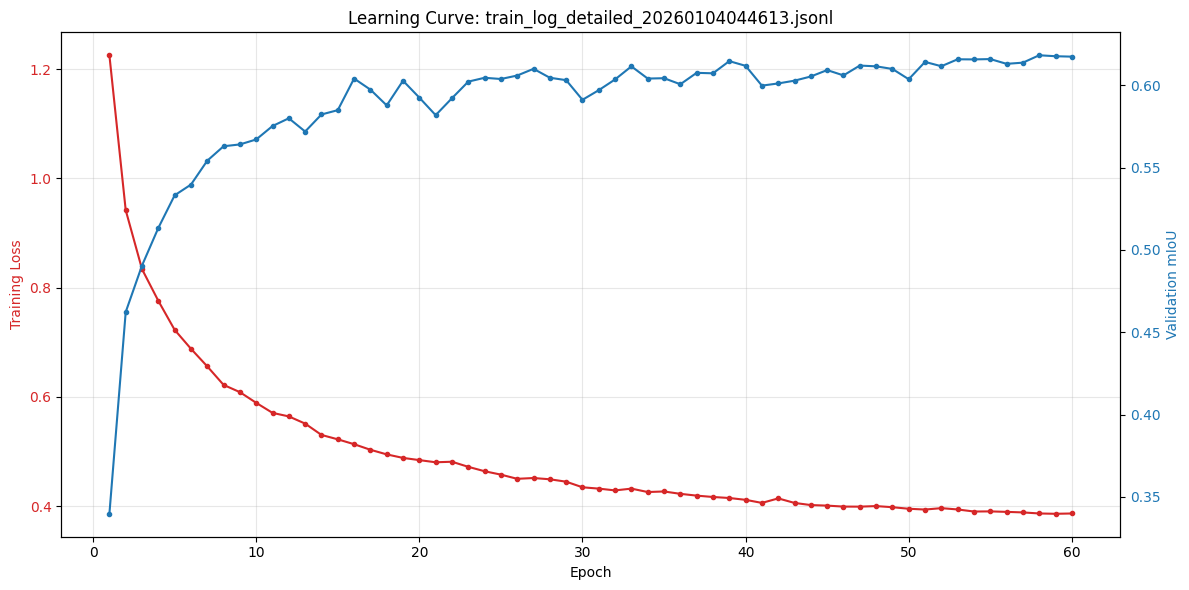

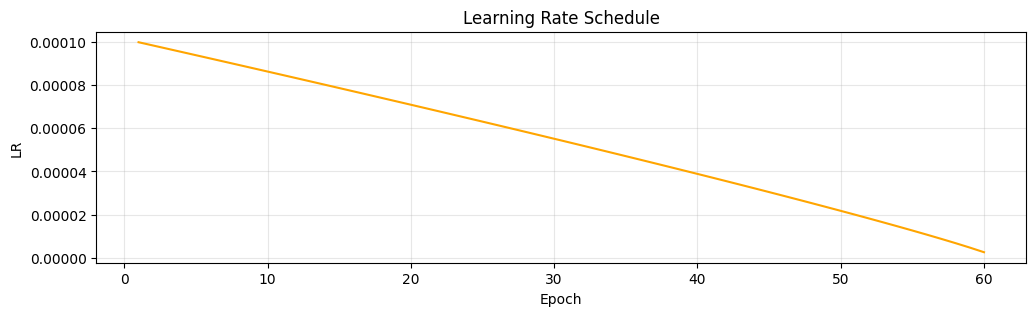

In [ ]:
import json
import matplotlib.pyplot as plt
import glob
import os

def plot_learning_curves(log_file):
    epochs = []
    losses = []
    mious = []
    lrs = []

    # ログファイルの読み込み
    with open(log_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            # ヘッダー行（info）はスキップ
            if "info" in data:
                continue

            epochs.append(data['epoch'])
            losses.append(data['loss'])
            mious.append(data['val_miou'])
            lrs.append(data['lr'])

    # プロットの作成
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Loss (左軸・赤)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss', color='tab:red')
    ax1.plot(epochs, losses, color='tab:red', label='Train Loss', marker='.')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True, alpha=0.3)

    # mIoU (右軸・青)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation mIoU', color='tab:blue')
    ax2.plot(epochs, mious, color='tab:blue', label='Val mIoU', marker='.')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'Learning Curve: {os.path.basename(log_file)}')
    fig.tight_layout()
    plt.show()

    # 学習率の確認用プロット（Poly Schedulerが効いているか確認）
    plt.figure(figsize=(12, 3))
    plt.plot(epochs, lrs, color='orange')
    plt.title("Learning Rate Schedule")
    plt.xlabel("Epoch")
    plt.ylabel("LR")
    plt.grid(True, alpha=0.3)
    plt.show()

# 自動で最新のログファイルを見つけて描画
log_files = sorted(glob.glob("train_log_detailed_*.jsonl"))
if log_files:
    latest_log = log_files[-1]
    print(f"Plotting: {latest_log}")
    plot_learning_curves(latest_log)
else:
    print("No log file found.")

In [ ]:
# -*- coding: utf-8 -*-
# NYUv2 val visualization (RGB | GT | Pred | RGB+Error) with FIXED palette -> ZIP
# - NO matplotlib colormap
# - GT and Pred share EXACT same palette mapping (ID -> RGB)
# - ignore_index(255) is shown as black by default

import os
import zipfile
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import VisionDataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, InterpolationMode
from torchvision import models

# =========================
# EDIT HERE
# =========================
DATASET_ROOT = "/content/data"
IMAGE_SIZE = (512, 512)

MODEL_PATH = "/content/checkpoints/model_20260103062841.pt"  # ←ここだけ直す
OUTDIR = "val_viz_fixed"
ZIP_PATH = "val_viz_fixed.zip"

MAX_SAVE = 50  # Noneで全件
SEED = 42
TRAIN_VAL_SPLIT = 0.9

NUM_WORKERS = 0
BATCH_SIZE = 1

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IGNORE_INDEX = 255

print("DEVICE:", DEVICE)
print("MODEL_PATH:", MODEL_PATH)

# =========================
# FIXED PALETTE (ID -> RGB)
# ここが「色の意味」そのもの。GTもPredも必ずこれを通す。
# =========================
PALETTE_13 = np.array([
    [  0,   0,   0],   # 0 wall
    [128,  64,  32],   # 1 floor
    [  0, 128, 255],   # 2 cabinet
    [255,   0, 128],   # 3 bed
    [  0, 255,   0],   # 4 chair
    [255, 128,   0],   # 5 sofa
    [255, 255,   0],   # 6 table
    [128, 128, 128],   # 7 door
    [  0, 255, 255],   # 8 window
    [  0,  64, 128],   # 9 bookshelf
    [255,   0,   0],   # 10 picture
    [128,   0, 255],   # 11 counter
    [ 64, 255, 128],   # 12 desk
], dtype=np.uint8)

# =========================
# Dataset helpers
# =========================
def pil_label_to_long_tensor(lbl_pil: Image.Image) -> torch.Tensor:
    arr = np.array(lbl_pil, dtype=np.int64)
    return torch.from_numpy(arr).long()

def depth_pil_to_tensor_01(depth_pil: Image.Image, size_hw):
    depth_pil = depth_pil.resize((size_hw[1], size_hw[0]), resample=Image.BILINEAR)
    arr = np.array(depth_pil)
    if arr.dtype == np.uint16 or (arr.max() > 255):
        arr = arr.astype(np.float32) / 65535.0
    else:
        arr = arr.astype(np.float32) / 255.0
    arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)
    arr = np.clip(arr, 0.0, 1.0)
    return torch.from_numpy(arr).unsqueeze(0)  # [1,H,W]

class NYUv2(VisionDataset):
    def __init__(self, root, split="train", include_depth=True,
                 image_transform=None, depth_transform=None, target_transform=None):
        super().__init__(root)
        assert split in ("train", "test")
        self.root = root
        self.split = split
        self.include_depth = include_depth

        images_dir = os.path.join(self.root, self.split, "image")
        img_names = sorted(os.listdir(images_dir))

        self.images = [os.path.join(images_dir, n) for n in img_names]
        self.depths = [os.path.join(self.root, self.split, "depth", n) for n in img_names]

        if self.split == "train":
            self.targets = [os.path.join(self.root, self.split, "label", n) for n in img_names]
        else:
            self.targets = None

        self.image_transform = image_transform
        self.depth_transform = depth_transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        depth = Image.open(self.depths[idx])

        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.depth_transform is not None:
            depth = self.depth_transform(depth)

        if self.split == "test":
            return (image, depth) if self.include_depth else image

        target = Image.open(self.targets[idx])
        if self.target_transform is not None:
            target = self.target_transform(target)

        return (image, depth, target) if self.include_depth else (image, target)

# =========================
# Model blocks (ResNet50-UNet + optional SE)
# =========================
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.conv1 = ConvBNReLU(in_ch + skip_ch, out_ch)
        self.conv2 = ConvBNReLU(out_ch, out_ch)

    def forward(self, x, skip):
        x = nn.functional.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class DepthStem(nn.Module):
    def __init__(self, z_ch=64):
        super().__init__()
        self.net = nn.Sequential(
            ConvBNReLU(1, 32, 3, 1),
            nn.MaxPool2d(2),
            ConvBNReLU(32, 48, 3, 1),
            nn.MaxPool2d(2),
            ConvBNReLU(48, z_ch, 3, 1),
            nn.MaxPool2d(2),
        )
    def forward(self, d):
        return self.net(d)

class SEFromDepth(nn.Module):
    def __init__(self, feat_ch, z_ch, reduction=16, alpha=0.05):
        super().__init__()
        self.alpha = float(alpha)
        hidden = max(32, feat_ch // reduction)
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(z_ch, hidden, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, feat_ch, 1, bias=True),
            nn.Sigmoid(),
        )
    def forward(self, F, z):
        g = self.fc(z)  # [B,C,1,1]
        scale = 1.0 + self.alpha * (g - 0.5)
        return F * scale

class ResNet50UNet(nn.Module):
    def __init__(self, num_classes=13, coarse_classes=5, in_channels=4,
                 pretrained=False,
                 use_se=False, se_z_ch=64, se_reduction=16, se_alpha=0.05,
                 se_dec_stages=("up1",)):
        super().__init__()
        self.use_se = use_se
        self.se_dec_stages = tuple(se_dec_stages)

        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)

        old_conv = resnet.conv1
        if in_channels != old_conv.in_channels:
            new_conv = nn.Conv2d(
                in_channels, old_conv.out_channels,
                kernel_size=old_conv.kernel_size,
                stride=old_conv.stride,
                padding=old_conv.padding,
                bias=False
            )
            with torch.no_grad():
                new_conv.weight[:, :3] = old_conv.weight
                mean_w = old_conv.weight.mean(dim=1, keepdim=True)
                for c in range(3, in_channels):
                    new_conv.weight[:, c:c+1] = mean_w
            resnet.conv1 = new_conv

        self.enc0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)  # 1/2
        self.pool = resnet.maxpool                                        # 1/4
        self.enc1 = resnet.layer1                                         # 1/4
        self.enc2 = resnet.layer2                                         # 1/8
        self.enc3 = resnet.layer3                                         # 1/16
        self.enc4 = resnet.layer4                                         # 1/32

        self.center = ConvBNReLU(2048, 1024)
        self.up4 = UpBlock(1024, 1024, 512)
        self.up3 = UpBlock(512,  512,  256)
        self.up2 = UpBlock(256,  256,  128)
        self.up1 = UpBlock(128,  64,   64)

        self.head_feat = ConvBNReLU(64, 64)
        self.head_out  = nn.Conv2d(64, num_classes, kernel_size=1)

        self.coarse_head = nn.Conv2d(256, coarse_classes, kernel_size=1)
        self.boundary_head = nn.Sequential(ConvBNReLU(64, 32), nn.Conv2d(32, 1, 1))

        if self.use_se:
            self.depth_stem = DepthStem(z_ch=se_z_ch)
            stage_to_ch = {"center":1024, "up4":512, "up3":256, "up2":128, "up1":64}
            self.se_dec = nn.ModuleDict()
            for st in self.se_dec_stages:
                self.se_dec[st] = SEFromDepth(stage_to_ch[st], se_z_ch, se_reduction, se_alpha)
        else:
            self.depth_stem = None
            self.se_dec = None

    def _apply_dec_se(self, feat, z, stage_name: str):
        if (not self.use_se) or (self.se_dec is None) or (stage_name not in self.se_dec):
            return feat
        z_ = nn.functional.interpolate(z, size=feat.shape[-2:], mode="bilinear", align_corners=False)
        return self.se_dec[stage_name](feat, z_)

    def forward(self, x, depth=None):
        c1 = self.enc0(x)
        t  = self.pool(c1)
        c2 = self.enc1(t)
        c3 = self.enc2(c2)
        c4 = self.enc3(c3)
        c5 = self.enc4(c4)

        z = self.depth_stem(depth) if self.use_se else None

        x = self.center(c5)
        if z is not None: x = self._apply_dec_se(x, z, "center")
        x = self.up4(x, c4)
        if z is not None: x = self._apply_dec_se(x, z, "up4")
        x = self.up3(x, c3)
        if z is not None: x = self._apply_dec_se(x, z, "up3")

        coarse_logits = self.coarse_head(x)

        x = self.up2(x, c2)
        if z is not None: x = self._apply_dec_se(x, z, "up2")
        x = self.up1(x, c1)
        if z is not None: x = self._apply_dec_se(x, z, "up1")

        x = nn.functional.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        feat = self.head_feat(x)
        fine_logits = self.head_out(feat)
        boundary_logit = self.boundary_head(x)
        return fine_logits, coarse_logits, boundary_logit

# =========================
# FIXED colorization (ID -> RGB)
# =========================
def id_to_rgb(mask_hw: np.ndarray, ignore_index=255, ignore_rgb=(0,0,0)) -> np.ndarray:
    """
    mask_hw: [H,W] int (0..12 or 255)
    returns: [H,W,3] uint8
    """
    out = np.zeros((mask_hw.shape[0], mask_hw.shape[1], 3), dtype=np.uint8)
    ign = (mask_hw == ignore_index)
    valid = ~ign
    m = mask_hw.copy()
    m[ign] = 0
    m = np.clip(m, 0, 12)
    out[valid] = PALETTE_13[m[valid]]
    out[ign] = np.array(ignore_rgb, dtype=np.uint8)
    return out

def denorm_rgb(rgb_tensor: torch.Tensor) -> Image.Image:
    mean = torch.tensor([0.485, 0.456, 0.406], device=rgb_tensor.device).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=rgb_tensor.device).view(3,1,1)
    x = (rgb_tensor * std + mean).clamp(0, 1)
    x = (x * 255).byte().permute(1,2,0).cpu().numpy()
    return Image.fromarray(x, mode="RGB")

def overlay_error(rgb_pil: Image.Image, gt_hw: np.ndarray, pred_hw: np.ndarray, ignore_index=255) -> Image.Image:
    rgb = np.array(rgb_pil).astype(np.float32)
    err = (gt_hw != ignore_index) & (gt_hw != pred_hw)
    if err.any():
        overlay = rgb.copy()
        overlay[err] = 0.6 * overlay[err] + 0.4 * np.array([255, 0, 0], dtype=np.float32)
        overlay = np.clip(overlay, 0, 255).astype(np.uint8)
        return Image.fromarray(overlay, mode="RGB")
    return rgb_pil

def stack_h(images):
    widths = [im.width for im in images]
    heights = [im.height for im in images]
    out = Image.new("RGB", (sum(widths), max(heights)))
    x = 0
    for im in images:
        out.paste(im, (x, 0))
        x += im.width
    return out

# =========================
# Transforms (same as eval)
# =========================
eval_image_transform = Compose([
    Resize(IMAGE_SIZE, interpolation=InterpolationMode.BILINEAR),
    ToTensor(),
    Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])

def depth_transform(pil):
    return depth_pil_to_tensor_01(pil, IMAGE_SIZE)

def target_transform(pil):
    pil = pil.resize((IMAGE_SIZE[1], IMAGE_SIZE[0]), resample=Image.NEAREST)
    return pil_label_to_long_tensor(pil)

# =========================
# Build val split (same indices rule)
# =========================
split_base = NYUv2(
    root=DATASET_ROOT,
    split="train",
    include_depth=True,
    image_transform=eval_image_transform,
    depth_transform=depth_transform,
    target_transform=target_transform,
)

n_total = len(split_base)
n_train = int(n_total * TRAIN_VAL_SPLIT)
n_val = n_total - n_train
g = torch.Generator().manual_seed(SEED)
_, val_subset = random_split(split_base, [n_train, n_val], generator=g)
val_ds = Subset(split_base, val_subset.indices)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Val samples: {len(val_ds)}")

# =========================
# Load checkpoint + auto-detect SE
# =========================
ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
if isinstance(ckpt, dict) and "state_dict" in ckpt and isinstance(ckpt["state_dict"], dict):
    sd = ckpt["state_dict"]
else:
    sd = ckpt

has_se = any(k.startswith("depth_stem.") or k.startswith("se_dec.") for k in sd.keys())
print("Detected SE in checkpoint:", has_se)

model = ResNet50UNet(
    num_classes=13,
    coarse_classes=5,
    in_channels=4,
    pretrained=False,
    use_se=has_se,
    se_z_ch=64,
    se_reduction=16,
    se_alpha=0.05,
    se_dec_stages=("up1",),
).to(DEVICE)

model.load_state_dict(sd, strict=True)
model.eval()

# =========================
# Generate panels with FIXED palette
# =========================
os.makedirs(OUTDIR, exist_ok=True)

saved = 0
with torch.no_grad():
    for i, (rgb, depth, label) in enumerate(tqdm(val_loader, desc="Saving fixed-color panels")):
        rgb = rgb.to(DEVICE, non_blocking=True)
        depth = depth.to(DEVICE, non_blocking=True)
        label = label.to(DEVICE, non_blocking=True)

        x = torch.cat([rgb.float(), depth.float()], dim=1)
        fine_logits, _, _ = model(x, depth=depth.float() if has_se else None)
        pred = fine_logits.argmax(dim=1)

        rgb_pil = denorm_rgb(rgb[0])

        gt_hw = label[0].cpu().numpy().astype(np.int32)
        pred_hw = pred[0].cpu().numpy().astype(np.int32)

        gt_rgb = id_to_rgb(gt_hw, ignore_index=IGNORE_INDEX, ignore_rgb=(0,0,0))
        pr_rgb = id_to_rgb(pred_hw, ignore_index=IGNORE_INDEX, ignore_rgb=(0,0,0))

        gt_pil = Image.fromarray(gt_rgb, mode="RGB")
        pr_pil = Image.fromarray(pr_rgb, mode="RGB")
        err_pil = overlay_error(rgb_pil, gt_hw, pred_hw, ignore_index=IGNORE_INDEX)

        panel = stack_h([rgb_pil, gt_pil, pr_pil, err_pil])
        panel.save(os.path.join(OUTDIR, f"{i:06d}.png"), optimize=True)

        saved += 1
        if MAX_SAVE is not None and saved >= MAX_SAVE:
            break

print(f"Saved: {saved} images -> {OUTDIR}")

# =========================
# Zip
# =========================
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED, compresslevel=9) as zf:
    for fn in sorted(os.listdir(OUTDIR)):
        if fn.lower().endswith(".png"):
            zf.write(os.path.join(OUTDIR, fn), arcname=fn)

print(f"ZIP created: {ZIP_PATH}")


DEVICE: cuda
MODEL_PATH: /content/checkpoints/model_20260103062841.pt
Val samples: 80
Detected SE in checkpoint: False


Saving fixed-color panels:   0%|          | 0/80 [00:00<?, ?it/s]/tmp/ipython-input-1516650115.py:299: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(x, mode="RGB")
/tmp/ipython-input-1516650115.py:417: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  gt_pil = Image.fromarray(gt_rgb, mode="RGB")
/tmp/ipython-input-1516650115.py:418: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pr_pil = Image.fromarray(pr_rgb, mode="RGB")
/tmp/ipython-input-1516650115.py:308: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(overlay, mode="RGB")
Saving fixed-color panels:  61%|██████▏   | 49/80 [00:27<00:17,  1.78it/s]


Saved: 50 images -> val_viz_fixed
ZIP created: val_viz_fixed.zip


In [ ]:
%ls -l checkpoints

total 4093968
-rw-r--r-- 1 root root 233561111 Jan  3 01:19 model_20260103011918.pt
-rw-r--r-- 1 root root 233561111 Jan  3 01:32 model_20260103013257.pt
-rw-r--r-- 1 root root 232859155 Jan  3 01:53 model_20260103015327.pt
-rw-r--r-- 1 root root 232859155 Jan  3 02:13 model_20260103021307.pt
-rw-r--r-- 1 root root 232859155 Jan  3 02:40 model_20260103024015.pt
-rw-r--r-- 1 root root 232800147 Jan  3 03:13 model_20260103031301.pt
-rw-r--r-- 1 root root 232800147 Jan  3 03:31 model_20260103033149.pt
-rw-r--r-- 1 root root 232800147 Jan  3 03:48 model_20260103034848.pt
-rw-r--r-- 1 root root 232800147 Jan  3 04:14 model_20260103041457.pt
-rw-r--r-- 1 root root 232814185 Jan  3 04:38 model_20260103043835.pt
-rw-r--r-- 1 root root 232814185 Jan  3 04:51 model_20260103045108.pt
-rw-r--r-- 1 root root 232882241 Jan  3 05:16 model_20260103051603.pt
-rw-r--r-- 1 root root 232883265 Jan  3 05:41 model_20260103054113.pt
-rw-r--r-- 1 root root 232688655 Jan  3 06:28 model_20260103062841.pt
-rw-r-

In [ ]:
# ------------------
#    Evaluation (DeepLabV3-ResNet50 / ResNet backbone)
# ------------------

ckpt = torch.load(final_path, map_location=device)

# もし「学習で checkpoint dict（model_state入り）」で保存している場合にも対応
if isinstance(ckpt, dict) and "model_state" in ckpt:
    model.load_state_dict(ckpt["model_state"])
else:
    model.load_state_dict(ckpt)

model.eval()

predictions = []

with torch.no_grad():
    print("Generating predictions...")
    for image, depth in tqdm(test_data):
        image = image.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)

        # 念のため：depthが3ch事故のときは1chに落とす
        if depth.dim() == 4 and depth.size(1) == 3:
            depth = depth[:, :1, :, :]

        x = torch.cat((image, depth), dim=1)   # [B,4,H,W]

        # DeepLabV3 は dict を返すので "out" を使う
        out = model(x)["out"]                  # [B,num_classes,H,W]
        pred = out.argmax(dim=1)               # [B,H,W]

        predictions.append(pred.cpu())

predictions = torch.cat(predictions, dim=0).numpy()
np.save("submission.npy", predictions)
print("Predictions saved to submission.npy")


"""## 提出方法

以下の3点をzip化し，Omnicampusの「最終課題 (セグメンテーション)」から提出してください．

- `submission.npy`
- `model.pt`や`model_best.pt`など，テストに使用した重み（拡張子は`.pt`のみ）
- 本Colab Notebook
"""

from zipfile import ZipFile, ZIP_DEFLATED

notebook_path = "/content/drive/MyDrive/Colab Notebooks/DL_Basic_2025_Competition_NYUv2_baseline.ipynb"

from zipfile import ZipFile, ZIP_DEFLATED

notebook_path = "/content/drive/MyDrive/code.ipynb"

with ZipFile("submission.zip",
             mode="w",
             compression=ZIP_DEFLATED,
             compresslevel=9) as zf:
    zf.write("submission.npy")
    zf.write(model_path)
#    zf.write(notebook_path,
#             arcname="code.ipynb")


NameError: name 'final_path' is not defined